## Clustering Analysis on Dermitology Dataset

### Setup and Data Loading

In [1]:
import numpy as np
import random
import torch
import tensorflow as tf

# Set seeds
np.random.seed(42)
random.seed(42)
torch.manual_seed(42)
tf.random.set_seed(42)

# If you're using GPU & CUDA:
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [2]:
from pso import ParticleSwarmOptimizedClustering
from apso import AdaptiveParticleSwarmOptimizedClustering
from particle import quantization_error, calc_sse
from utils import normalize
from kmeans import KMeans
import pandas as pd
import numpy as np
from sklearn.metrics import silhouette_score
import random
random.seed(2024)
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer



### Data Preprocessing

In [4]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
dermatology = fetch_ucirepo(id=33) 
  
data = dermatology.data.features
data['class'] = dermatology.data.targets
  
# metadata 
print(dermatology.metadata) 
  


{'uci_id': 33, 'name': 'Dermatology', 'repository_url': 'https://archive.ics.uci.edu/dataset/33/dermatology', 'data_url': 'https://archive.ics.uci.edu/static/public/33/data.csv', 'abstract': 'Aim for this dataset is to determine the type of Eryhemato-Squamous Disease.', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 366, 'num_features': 34, 'feature_types': ['Categorical', 'Integer'], 'demographics': ['Age'], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1998, 'last_updated': 'Wed Feb 14 2024', 'dataset_doi': '10.24432/C5FK5P', 'creators': ['Nilsel Ilter', 'H. Guvenir'], 'intro_paper': {'ID': 387, 'type': 'NATIVE', 'title': 'Learning differential diagnosis of erythemato-squamous diseases using voting feature intervals', 'authors': 'H. Altay Güvenir, G. Demiröz, N. Ilter', 'venue': 'Artif. Intell. Medicine', 'year': 1998, 'journal': No

In [5]:
# variable information 
print(dermatology.variables) 

                                           name     role     type demographic  \
0                                      erythema  Feature  Integer        None   
1                                       scaling  Feature  Integer        None   
2                              definite-borders  Feature  Integer        None   
3                                       itching  Feature  Integer        None   
4                            koebner phenomenon  Feature  Integer        None   
5                             polygonal papules  Feature  Integer        None   
6                            follicular papules  Feature  Integer        None   
7                      oral-mucosal involvement  Feature  Integer        None   
8                        knee elbow involvement  Feature  Integer        None   
9                             scalp involvement  Feature  Integer        None   
10                               family history  Feature   Binary        None   
11                         m

In [6]:
# Print initial data info
print("Initial data shape:", data.shape)


Initial data shape: (366, 35)


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 35 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   erythema                                     366 non-null    int64  
 1   scaling                                      366 non-null    int64  
 2   definite-borders                             366 non-null    int64  
 3   itching                                      366 non-null    int64  
 4   koebner phenomenon                           366 non-null    int64  
 5   polygonal papules                            366 non-null    int64  
 6   follicular papules                           366 non-null    int64  
 7   oral-mucosal involvement                     366 non-null    int64  
 8   knee elbow involvement                       366 non-null    int64  
 9   scalp involvement                            366 non-null    int64  
 10  fa

In [8]:
data.describe()

erythema     scaling  definite-borders     itching  \
count  366.000000  366.000000        366.000000  366.000000   
mean     2.068306    1.795082          1.549180    1.366120   
std      0.664753    0.701527          0.907525    1.138299   
min      0.000000    0.000000          0.000000    0.000000   
25%      2.000000    1.000000          1.000000    0.000000   
50%      2.000000    2.000000          2.000000    1.000000   
75%      2.000000    2.000000          2.000000    2.000000   
max      3.000000    3.000000          3.000000    3.000000   

       koebner phenomenon  polygonal papules  follicular papules  \
count          366.000000         366.000000          366.000000   
mean             0.633880           0.448087            0.166667   
std              0.908016           0.957327            0.570588   
min              0.000000           0.000000            0.000000   
25%              0.000000           0.000000            0.000000   
50%              0.000000           0.000000            0.000000   
75%              1.000000           0.000000            0.000000   
max              3.000000           3.000000            3.000000   

       oral-mucosal involvement  knee elbow involvement  scalp involvement  \
count                366.000000              366.000000         366.000000   
mean                   0.377049                0.614754           0.519126   
std                    0.834147                0.982979           0.905639   
min                    0.000000                0.000000           0.000000   
25%                    0.000000                0.000000           0.000000   
50%                    0.000000                0.000000           0.000000   
75%                    0.000000                1.000000           1.000000   
max                    3.000000                3.000000           3.000000   

       ...  disappearance of the granular layer  \
count  ...                           366.000000   
mean   ...                             0.464481   
std    ...                             0.864899   
min    ...                             0.000000   
25%    ...                             0.000000   
50%    ...                             0.000000   
75%    ...                             1.000000   
max    ...                             3.000000   

       vacuolisation and damage of the basal layer  spongiosis  \
count                                   366.000000  366.000000   
mean                                      0.456284    0.953552   
std                                       0.954873    1.130172   
min                                       0.000000    0.000000   
25%                                       0.000000    0.000000   
50%                                       0.000000    0.000000   
75%                                       0.000000    2.000000   
max                                       3.000000    3.000000   

       saw-tooth appearance of retes  follicular horn plug  \
count                     366.000000            366.000000   
mean                        0.453552              0.103825   
std                         0.954744              0.450433   
min                         0.000000              0.000000   
25%                         0.000000              0.000000   
50%                         0.000000              0.000000   
75%                         0.000000              0.000000   
max                         3.000000              3.000000   

       perifollicular parakeratosis  inflammatory monoluclear infiltrate  \
count                    366.000000                           366.000000   
mean                       0.114754                             1.866120   
std                        0.488723                             0.726108   
min                        0.000000                             0.000000   
25%                        0.000000                             1.000000   
50%                        0.000000                    

In [9]:
data['class'].unique()

array([2, 1, 3, 5, 4, 6], dtype=int64)

In [10]:
# Move 'class' to the last column
class_column = data['class']
data = data.drop('class', axis=1)
data['class'] = class_column

In [11]:
# Separate features and target
y = data['class'].values
x = data.drop('class', axis=1)

In [12]:
# Handle NaN values using SimpleImputer
imputer = SimpleImputer(strategy='mean')
X_imputed = imputer.fit_transform(x)

In [13]:
# Standardize the data
scaler = StandardScaler()
x = scaler.fit_transform(X_imputed)

In [14]:
# Print information to verify
print("\nShape of x after processing:", x.shape)
print("First few rows of x:")
print(x[:5])



Shape of x after processing: (366, 34)
First few rows of x:
[[-0.1028946   0.29250271 -1.70937509  1.4373339  -0.69904891 -0.46870154
  -0.29249615 -0.45263665  0.39245327 -0.57399979 -0.37914377 -0.46552851
  -0.33884986 -0.67103516 -0.39445573  1.47895109  0.06143857 -0.69744206
  -1.40740727 -0.62909261 -0.85458144 -0.61332752 -0.44064385 -0.47897227
  -0.46383126 -0.53777008 -0.47850217  1.81321918 -0.47570133 -0.23081653
  -0.23512537 -1.19445878 -0.50221531  1.23580775]
 [ 1.40348234  1.71991595  1.60084334  0.55762787  0.40376101 -0.46870154
  -0.29249615 -0.45263665  0.39245327  0.53170507  2.63752189 -0.46552851
  -0.33884986  0.55695918 -0.39445573 -0.33443618  0.06143857 -0.69744206
   0.77526672  1.2659518   0.86870675  1.32182654  2.54594223  0.8391018
  -0.46383126 -0.53777008 -0.47850217 -0.84487783 -0.47570133 -0.23081653
  -0.23512537 -1.19445878 -0.50221531 -1.86958371]
 [-0.1028946  -1.13491053  0.49743719  1.4373339   0.40376101  2.6693124
  -0.29249615  3.1487767 

In [15]:
print("Any NaN values in final x:", np.isnan(x).any())

Any NaN values in final x: False


In [16]:
unique, counts = np.unique(y, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class distribution:")
class_distribution

Class distribution:


{1: 112, 2: 61, 3: 72, 4: 49, 5: 52, 6: 20}

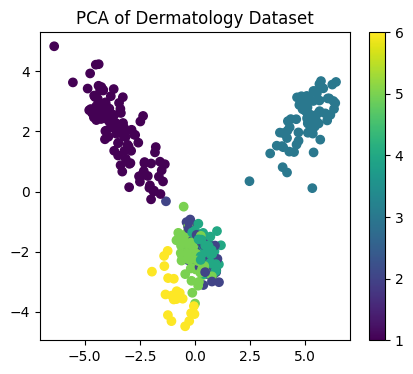

In [17]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
x_pca = pca.fit_transform(x)

plt.figure(figsize=(5, 4))
plt.scatter(x_pca[:, 0], x_pca[:, 1], c=y, cmap='viridis')
plt.colorbar()
plt.title('PCA of Dermatology Dataset')
plt.show()

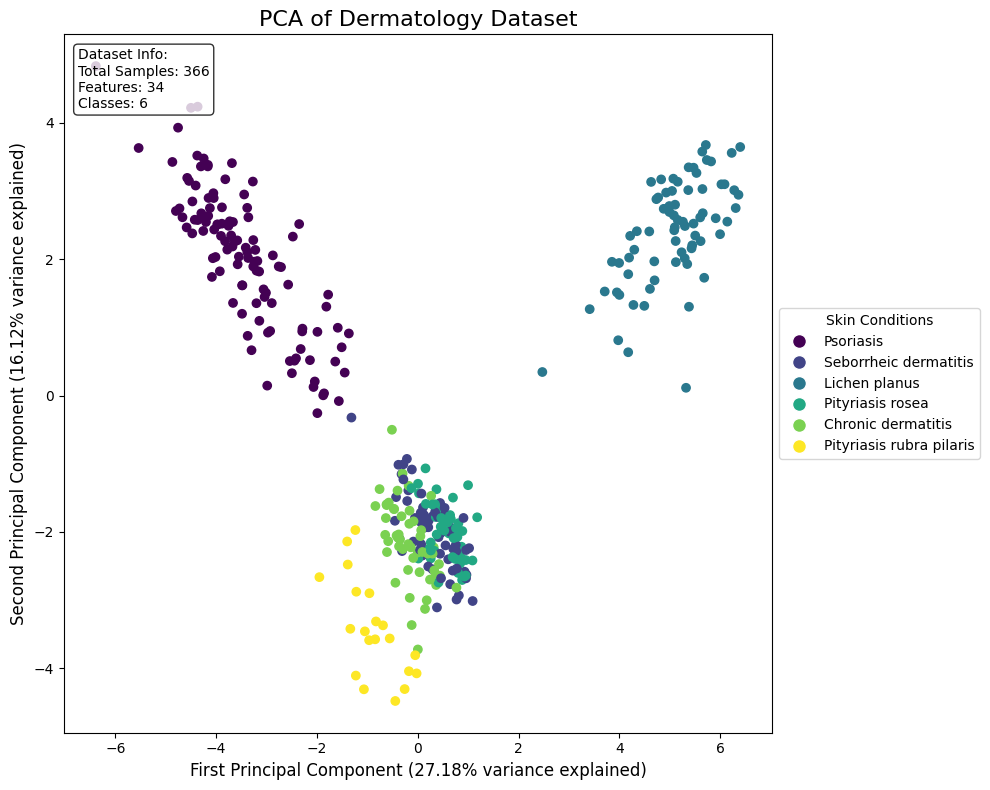

In [18]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Perform PCA
pca = PCA(n_components=2)
x_pca = pca.fit_transform(x)

# Set up the plot
plt.figure(figsize=(10, 8))
scatter = plt.scatter(x_pca[:, 0], x_pca[:, 1], c=y, cmap='viridis')

# Add title and labels
plt.title('PCA of Dermatology Dataset', fontsize=16)
plt.xlabel(f'First Principal Component ({pca.explained_variance_ratio_[0]:.2%} variance explained)', fontsize=12)
plt.ylabel(f'Second Principal Component ({pca.explained_variance_ratio_[1]:.2%} variance explained)', fontsize=12)



# Create a legend
class_names = ['Psoriasis', 'Seborrheic dermatitis', 'Lichen planus', 
               'Pityriasis rosea', 'Chronic dermatitis', 'Pityriasis rubra pilaris']
legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=class_names[i], 
                   markerfacecolor=scatter.cmap(scatter.norm(i+1)), markersize=10)
                   for i in range(len(class_names))]
plt.legend(handles=legend_elements, title='Skin Conditions', loc='center left', bbox_to_anchor=(1, 0.5))

# Add information about the dataset
info_text = f"Dataset Info:\n" \
            f"Total Samples: {len(x)}\n" \
            f"Features: {x.shape[1]}\n" \
            f"Classes: {len(np.unique(y))}"
plt.text(0.02, 0.98, info_text, transform=plt.gca().transAxes, fontsize=10,
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Adjust layout and display
plt.tight_layout()
plt.show()

## Clustering Experiments

### K-Means++ Implementation

In [19]:
# K-Means++
kmeanspp = {
    'silhouette': [],
    'sse': [],
    'quantization': [],
    'sse_history': []  # Added for consistency, though K-Means++ doesn't have iteration history
}
for _ in range(10):
    kmean_rep = KMeans(n_cluster=6, init_pp=True)
    kmean_rep.fit(x)
    predicted_kmean_rep = kmean_rep.predict(x)
    silhouette = silhouette_score(x, predicted_kmean_rep)
    sse = kmean_rep.SSE
    quantization = quantization_error(centroids=kmean_rep.centroid, data=x, labels=predicted_kmean_rep)
    kmeanspp['silhouette'].append(silhouette)
    kmeanspp['sse'].append(sse)
    kmeanspp['quantization'].append(quantization)
    kmeanspp['sse_history'].append([sse])  # Single-element list for consistency

### PSO Clustering Implementation

In [20]:
import numpy as np
from sklearn.metrics import silhouette_score

pso_plain = {
    'silhouette': [],
    'sse': [],
    'quantization': [],
    'sse_history': []
}

max_attempts = 1  # Maximum number of attempts to get a valid clustering

for _ in range(10):
    attempt = 0
    while attempt < max_attempts:
        pso_rep = ParticleSwarmOptimizedClustering(
            n_cluster=6, n_particles=50, data=x, hybrid=False, max_iter=1000, print_debug=1000)
        sse_history = pso_rep.run()  # Now returns SSE history
        pso_kmeans = KMeans(n_cluster=6, init_pp=False, seed=2024)
        pso_kmeans.centroid = pso_rep.gbest_centroids.copy()
        predicted_pso_rep = pso_kmeans.predict(x)
        
        unique_labels = np.unique(predicted_pso_rep)
        if len(unique_labels) > 1:
            # Valid clustering found
            break
        attempt += 1
    
    if attempt == max_attempts:
        print(f"Failed to find a valid clustering after {max_attempts} attempts. Skipping this iteration.")
        continue
    
    sse = calc_sse(centroids=pso_rep.gbest_centroids, data=x, labels=predicted_pso_rep)
    quantization = pso_rep.gbest_score
    silhouette = silhouette_score(x, predicted_pso_rep)
    pso_plain['silhouette'].append(silhouette)
    pso_plain['sse'].append(sse) 
    pso_plain['quantization'].append(quantization)
    pso_plain['sse_history'].append(sse_history)

print("PSO Plain clustering completed. Raw data collected for further analysis.")

Failed to find a valid clustering after 1 attempts. Skipping this iteration.
Failed to find a valid clustering after 1 attempts. Skipping this iteration.
Failed to find a valid clustering after 1 attempts. Skipping this iteration.
Failed to find a valid clustering after 1 attempts. Skipping this iteration.
Failed to find a valid clustering after 1 attempts. Skipping this iteration.
Failed to find a valid clustering after 1 attempts. Skipping this iteration.
Failed to find a valid clustering after 1 attempts. Skipping this iteration.
Failed to find a valid clustering after 1 attempts. Skipping this iteration.
PSO Plain clustering completed. Raw data collected for further analysis.


### Hybrid PSO Clustering Implementation

In [21]:
import numpy as np
from sklearn.metrics import silhouette_score

pso_hybrid = {
    'silhouette': [],
    'sse': [],
    'quantization': [],
    'sse_history': []
}

max_attempts = 1  # Maximum number of attempts to get a valid clustering

for _ in range(10):
    attempt = 0
    while attempt < max_attempts:
        pso_rep = ParticleSwarmOptimizedClustering(
            n_cluster=6, n_particles=50, data=x, hybrid=True, max_iter=1000, print_debug=1000)
        sse_history = pso_rep.run()  # Now returns SSE history
        pso_kmeans = KMeans(n_cluster=6, init_pp=False, seed=2024)
        pso_kmeans.centroid = pso_rep.gbest_centroids.copy()
        predicted_pso_rep = pso_kmeans.predict(x)
        
        unique_labels = np.unique(predicted_pso_rep)
        if len(unique_labels) > 1:
            # Valid clustering found
            break
        attempt += 1
    
    if attempt == max_attempts:
        print(f"Failed to find a valid clustering after {max_attempts} attempts. Skipping this iteration.")
        continue
    
    sse = calc_sse(centroids=pso_rep.gbest_centroids, data=x, labels=predicted_pso_rep)
    quantization = pso_rep.gbest_score
    silhouette = silhouette_score(x, predicted_pso_rep)
    pso_hybrid['silhouette'].append(silhouette)
    pso_hybrid['sse'].append(sse)
    pso_hybrid['quantization'].append(quantization)
    pso_hybrid['sse_history'].append(sse_history)

print("PSO Hybrid clustering completed. Raw data collected for further analysis.")

Failed to find a valid clustering after 1 attempts. Skipping this iteration.


C:\Users\shiva\AppData\Roaming\Python\Python310\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\shiva\AppData\Roaming\Python\Python310\site-packages\numpy\core\_methods.py:184: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


Failed to find a valid clustering after 1 attempts. Skipping this iteration.
Failed to find a valid clustering after 1 attempts. Skipping this iteration.
Failed to find a valid clustering after 1 attempts. Skipping this iteration.
Failed to find a valid clustering after 1 attempts. Skipping this iteration.
Failed to find a valid clustering after 1 attempts. Skipping this iteration.
Failed to find a valid clustering after 1 attempts. Skipping this iteration.
Failed to find a valid clustering after 1 attempts. Skipping this iteration.
PSO Hybrid clustering completed. Raw data collected for further analysis.


### APSO Implementations (Plain and Hybrid)

In [22]:
# APSO Plain
apso_plain = {
    'silhouette': [],
    'sse': [],
    'quantization': [],
    'sse_history': []
}

max_attempts = 1  # Maximum number of attempts to get a valid clustering

for _ in range(10):
    attempt = 0
    while attempt < max_attempts:
        apso_rep = AdaptiveParticleSwarmOptimizedClustering(
            n_cluster=6, n_particles=50, data=x, hybrid=False, max_iter=1000, print_debug=1000)
        sse_history = apso_rep.run()  # Now returns SSE history
        apso_kmeans = KMeans(n_cluster=6, init_pp=False, seed=2024)
        apso_kmeans.centroid = apso_rep.gbest_centroids.copy()
        predicted_apso_rep = apso_kmeans.predict(x)
        
        unique_labels = np.unique(predicted_apso_rep)
        if len(unique_labels) > 1:
            # Valid clustering found
            break
        attempt += 1
    
    if attempt == max_attempts:
        print(f"Failed to find a valid clustering after {max_attempts} attempts. Skipping this iteration.")
        continue
    
    sse = calc_sse(centroids=apso_rep.gbest_centroids, data=x, labels=predicted_apso_rep)
    quantization = apso_rep.gbest_score
    silhouette = silhouette_score(x, predicted_apso_rep)
    apso_plain['silhouette'].append(silhouette)
    apso_plain['sse'].append(sse)
    apso_plain['quantization'].append(quantization)
    apso_plain['sse_history'].append(sse_history)

print("APSO Plain clustering completed. Raw data collected for further analysis.")

APSO Plain clustering completed. Raw data collected for further analysis.


In [23]:
# APSO Hybrid
apso_hybrid = {
    'silhouette': [],
    'sse': [],
    'quantization': [],
    'sse_history': []
}

max_attempts = 1  # Maximum number of attempts to get a valid clustering

for _ in range(10):

    attempt = 0

    while attempt < max_attempts:
        apso_rep = AdaptiveParticleSwarmOptimizedClustering(
            n_cluster=6, n_particles=30, data=x, hybrid=True, max_iter=1000, print_debug=1000)
        sse_history = apso_rep.run()  # Now returns SSE history
        apso_kmeans = KMeans(n_cluster=6, init_pp=False, seed=2024)
        apso_kmeans.centroid = apso_rep.gbest_centroids.copy()
        predicted_apso_rep = apso_kmeans.predict(x)
        
        unique_labels = np.unique(predicted_apso_rep)
        if len(unique_labels) > 1:
            # Valid clustering found
            break
        attempt += 1
    
    if attempt == max_attempts:
        print(f"Failed to find a valid clustering after {max_attempts} attempts. Skipping this iteration.")
        continue
    
    sse = calc_sse(centroids=apso_rep.gbest_centroids, data=x, labels=predicted_apso_rep)
    quantization = apso_rep.gbest_score
    silhouette = silhouette_score(x, predicted_apso_rep)
    apso_hybrid['silhouette'].append(silhouette)
    apso_hybrid['sse'].append(sse)
    apso_hybrid['quantization'].append(quantization)
    apso_hybrid['sse_history'].append(sse_history)

print("APSO Hybrid clustering completed. Raw data collected for further analysis.")

APSO Hybrid clustering completed. Raw data collected for further analysis.


### Clustering Algorithm Performance Benchmark

In [24]:
import numpy as np
import pandas as pd

def calculate_statistics(data):
    # Convert to numpy array if it's not already
    if not isinstance(data, np.ndarray):
        data = np.array(data)
    
    # Check if the array is empty or all elements are non-numeric
    if data.size == 0 or not np.issubdtype(data.dtype, np.number):
        return {
            'mean': np.nan,
            'stdev': np.nan,
            'min': np.nan,
            'max': np.nan,
            'percentile_75': np.nan,
            'valid_count': 0
        }
    
    # Remove any non-numeric values
    valid_data = data[~np.isnan(data)]
    
    if len(valid_data) == 0:
        return {
            'mean': np.nan,
            'stdev': np.nan,
            'min': np.nan,
            'max': np.nan,
            'percentile_75': np.nan,
            'valid_count': 0
        }
    
    return {
        'mean': np.around(np.mean(valid_data), decimals=10),
        'stdev': np.around(np.std(valid_data), decimals=10),
        'min': np.around(np.min(valid_data), decimals=10),
        'max': np.around(np.max(valid_data), decimals=10),
        'percentile_75': np.around(np.percentile(valid_data, 75), decimals=10),
        'valid_count': len(valid_data)
    }

# The rest of your code remains the same
methods = ['K-Means++', 'PSO', 'PSO Hybrid', 'APSO', 'APSO Hybrid']
metrics = ['sse', 'silhouette', 'quantization']
results = [kmeanspp, pso_plain, pso_hybrid, apso_plain, apso_hybrid]

benchmark = {'method': methods}

for i, method in enumerate(methods):
    valid_runs = np.sum(~np.isnan(results[i][metrics[0]]))  # Assuming if SSE is valid, the run is valid
    success_rate = valid_runs / 10  # 10 iterations
    benchmark['success_rate'] = benchmark.get('success_rate', []) + [success_rate]
    
    for metric in metrics:
        stats = calculate_statistics(results[i][metric])
        for stat, value in stats.items():
            if stat != 'valid_count':  # We don't need to include this in the final DataFrame
                benchmark[f'{metric}_{stat}'] = benchmark.get(f'{metric}_{stat}', []) + [value]

benchmark_df = pd.DataFrame.from_dict(benchmark)

# Reorder columns for better readability
column_order = ['method', 'success_rate'] + [f'{metric}_{stat}' for metric in metrics for stat in ['mean', 'stdev', 'min', 'max', 'percentile_75']]
benchmark_df = benchmark_df[column_order]

benchmark_df

method  success_rate     sse_mean    sse_stdev      sse_min  \
0    K-Means++           1.0  6543.524716   371.149133  6123.421775   
1          PSO           0.2  9074.048464   361.026721  8713.021743   
2   PSO Hybrid           0.2  5669.681119    82.503044  5587.178076   
3         APSO           1.0  9589.116583  1080.696957  8151.456576   
4  APSO Hybrid           1.0  7359.942329  2611.976217  5581.513737   

        sse_max  sse_percentile_75  silhouette_mean  silhouette_stdev  \
0   7104.026586        6866.355166         0.156486          0.022908   
1   9435.075185        9254.561825         0.085218          0.001098   
2   5752.184163        5710.932641         0.226354          0.004429   
3  11572.883457       10426.736888         0.134936          0.041810   
4  13029.099342        6690.693935         0.185469          0.046435   

   silhouette_min  silhouette_max  silhouette_percentile_75  \
0        0.131415        0.190088                  0.180359   
1        0.084121        0.086316                  0.085767   
2        0.221925        0.230783                  0.228569   
3        0.067457        0.192552                  0.163074   
4        0.093495        0.249014                  0.222741   

   quantization_mean  quantization_stdev  quantization_min  quantization_max  \
0           3.911518            0.059300          3.798236          4.015050   
1           3.797639            0.110418          3.687222          3.908057   
2           3.695136            0.002580          3.692556          3.697716   
3           3.912770            0.195286          3.616933          4.237255   
4           3.737372            0.175077          3.451366          4.041989   

   quantization_percentile_75  
0                    3.925737  
1                    3.852848  
2                    3.696426  
3                    4.052299  
4                    3.880706

### Convergence Analysis Visualization

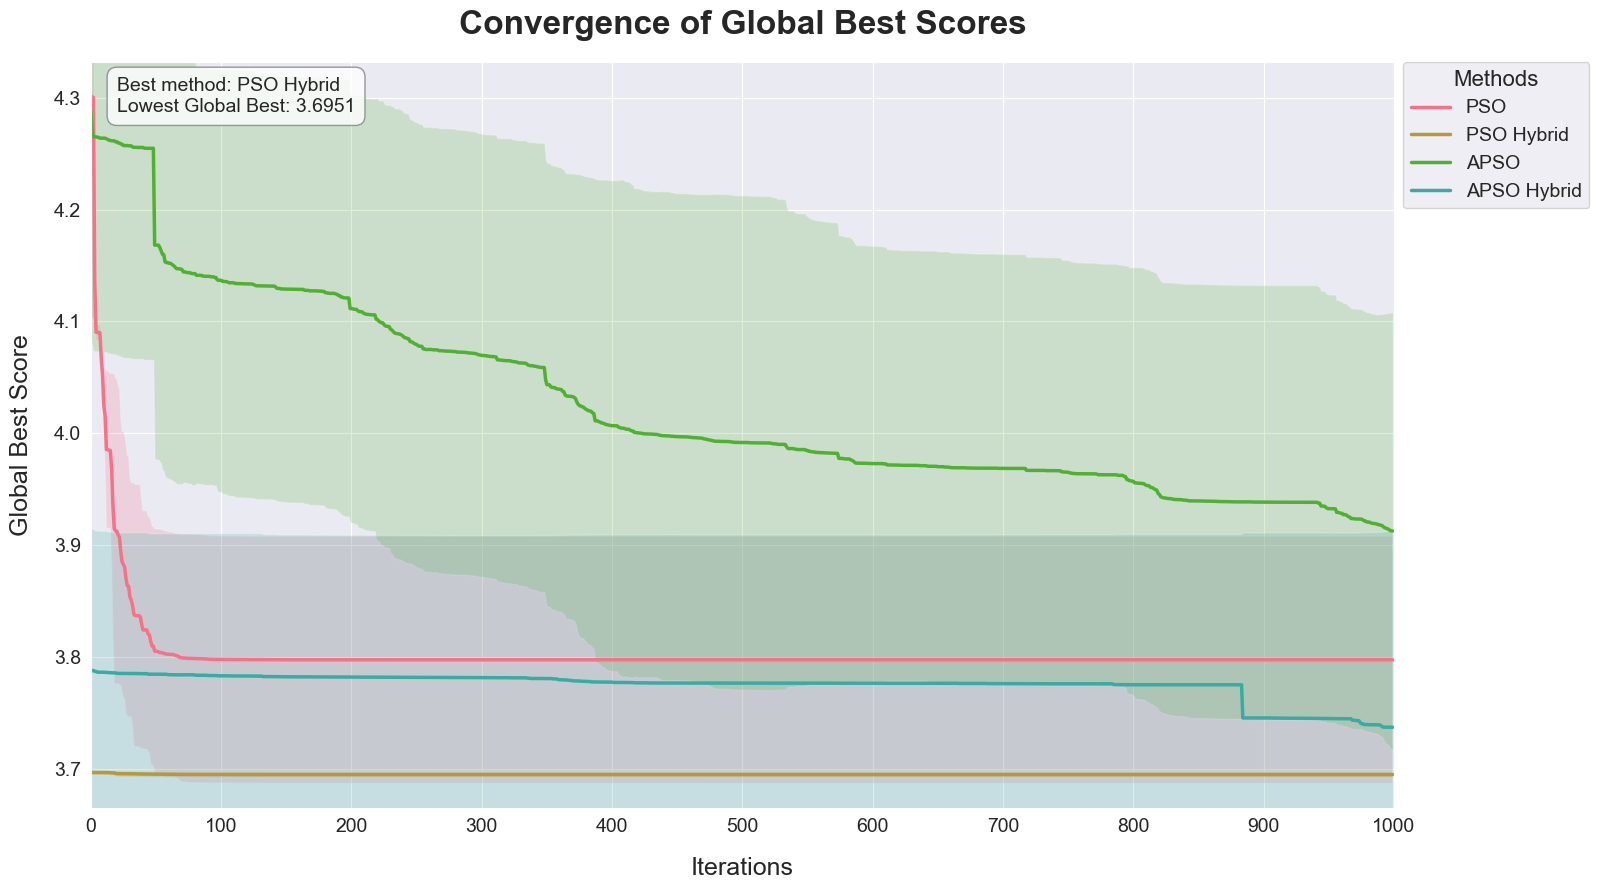

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from matplotlib.ticker import MaxNLocator
methods = ['K-Means++', 'PSO', 'PSO Hybrid', 'APSO', 'APSO Hybrid']
def plot_gbest_convergence(results_dict, benchmark_df):
    plt.figure(figsize=(16, 9))
    sns.set_style("darkgrid")
    sns.set_palette("husl")
    
    methods = ['PSO', 'PSO Hybrid', 'APSO', 'APSO Hybrid']
    
    all_gbest_values = []
    for method in methods:
        gbest_histories = results_dict[method]['sse_history']  # This is actually gbest history
        max_length = max(len(history) for history in gbest_histories)
        padded_histories = [history + [history[-1]]*(max_length - len(history)) for history in gbest_histories]
        mean_gbest_history = np.mean(padded_histories, axis=0)
        std_gbest_history = np.std(padded_histories, axis=0)
        
        all_gbest_values.extend(mean_gbest_history)
        
        iterations = range(len(mean_gbest_history))
        plt.plot(iterations, mean_gbest_history, label=method, linewidth=2.5)
        plt.fill_between(iterations, mean_gbest_history - std_gbest_history, 
                         mean_gbest_history + std_gbest_history, alpha=0.2)
    
    plt.title('Convergence of Global Best Scores', fontsize=24, fontweight='bold', pad=20)
    plt.xlabel('Iterations', fontsize=18, labelpad=15)
    plt.ylabel('Global Best Score', fontsize=18, labelpad=15)
    plt.legend(fontsize=14, title='Methods', title_fontsize=16, loc='upper right', 
               bbox_to_anchor=(1.15, 1), borderaxespad=0.)
    
    plt.xlim(0, max_length)
    
    # Set y-axis limits to focus on the relevant range
    min_gbest = min(all_gbest_values)
    max_gbest = max(all_gbest_values)
    gbest_range = max_gbest - min_gbest
    plt.ylim(min_gbest - 0.05 * gbest_range, max_gbest + 0.05 * gbest_range)
    
    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
    
    # Add annotations
    best_method = benchmark_df.loc[benchmark_df['quantization_mean'].idxmin(), 'method']
    best_value = benchmark_df['quantization_mean'].min()
    plt.annotate(f'Best method: {best_method}\nLowest Global Best: {best_value:.4f}', 
                 xy=(0.02, 0.98), xycoords='axes fraction', va='top',
                 fontsize=14, bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8))
    
    plt.tight_layout()
    plt.show()

# Usage
plot_gbest_convergence({
    'PSO': pso_plain,
    'PSO Hybrid': pso_hybrid,
    'APSO': apso_plain,
    'APSO Hybrid': apso_hybrid
}, benchmark_df)

### Performance Analysis



C:\Users\shiva\AppData\Local\Temp\ipykernel_16176\872286414.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
C:\Users\shiva\AppData\Local\Temp\ipykernel_16176\872286414.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
C:\Users\shiva\AppData\Local\Temp\ipykernel_16176\872286414.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')


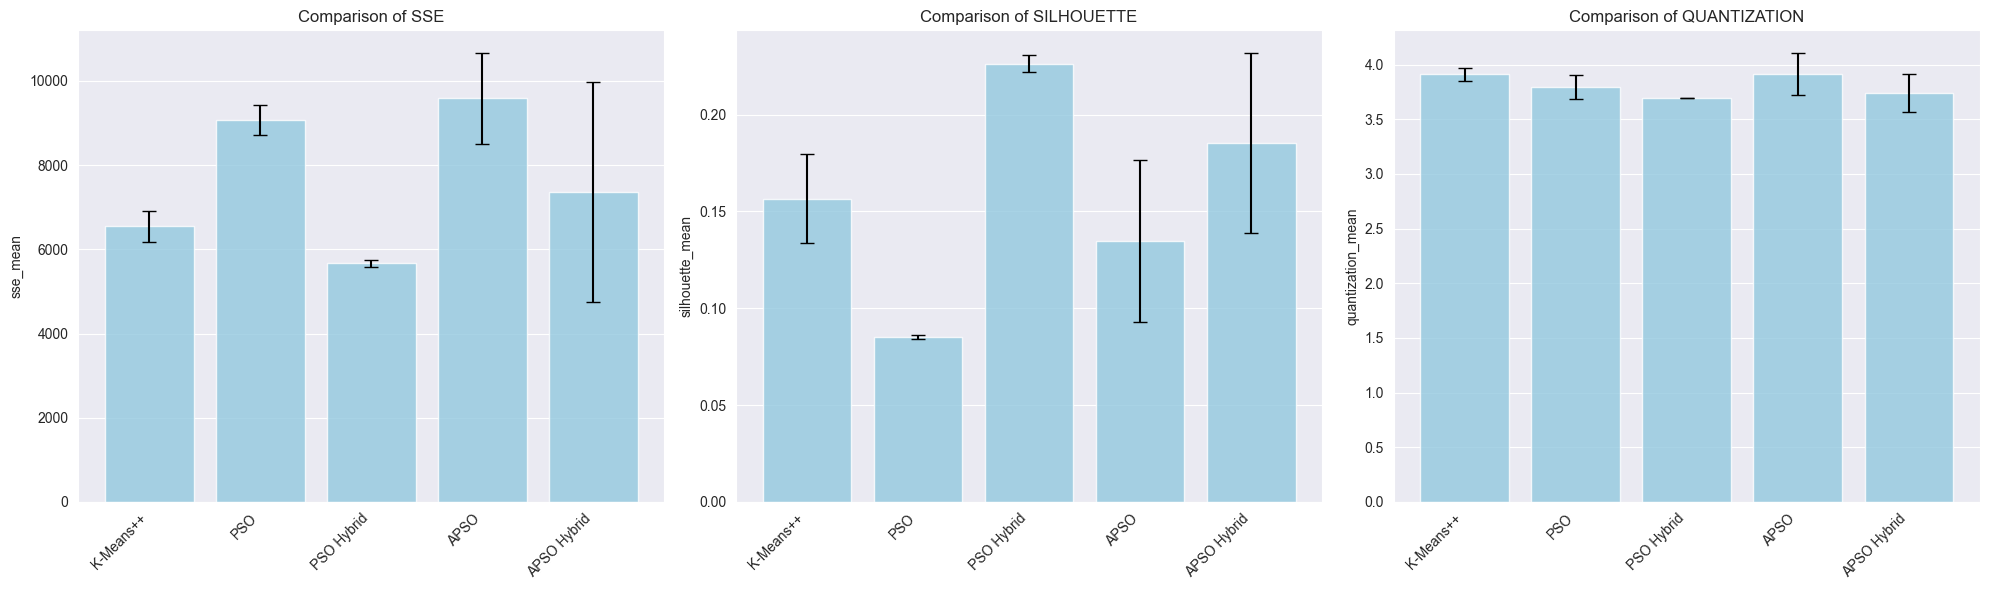

In [26]:


def plot_performance_comparison(benchmark_df):
    metrics = ['sse', 'silhouette', 'quantization']
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    for i, metric in enumerate(metrics):
        mean_col = f'{metric}_mean'
        std_col = f'{metric}_stdev'
        
        # Create the bar plot
        sns.barplot(x='method', y=mean_col, data=benchmark_df, ax=axes[i], 
                    capsize=0.1, color='skyblue', alpha=0.8)
        
        # Add error bars
        axes[i].errorbar(x=range(len(benchmark_df)), y=benchmark_df[mean_col], 
                         yerr=benchmark_df[std_col], fmt='none', color='black', capsize=5)
        
        axes[i].set_title(f'Comparison of {metric.upper()}')
        axes[i].set_xlabel('')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
    
    plt.tight_layout()
    plt.show()

# Usage
plot_performance_comparison(benchmark_df)

### Stability Analysis



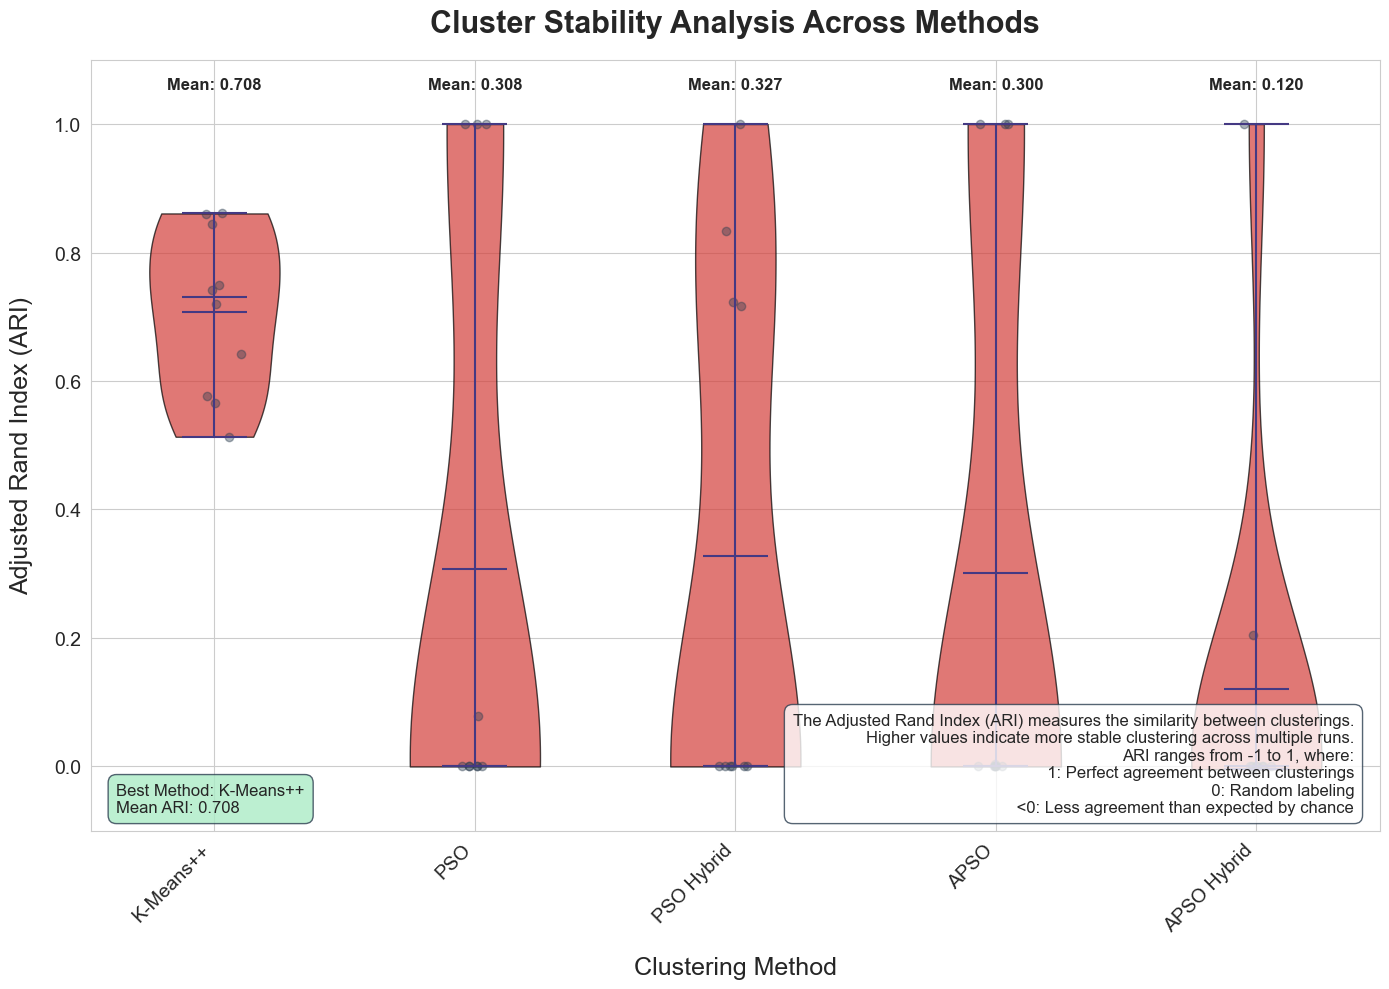

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin

def enhanced_cluster_stability_analysis(data, methods, n_runs=5):
    stability_scores = {method: [] for method in methods}
    
    for method in methods:
        labels_list = []
        for _ in range(n_runs):
            if method == 'K-Means++':
                kmeans = KMeans(n_clusters=6, init='k-means++', random_state=None)
                kmeans.fit(data)
                labels = kmeans.predict(data)
            else:
                if 'PSO' in method:
                    pso = ParticleSwarmOptimizedClustering(n_cluster=6, n_particles=50, data=data, hybrid=('Hybrid' in method), max_iter=1000)
                else:  # APSO
                    pso = AdaptiveParticleSwarmOptimizedClustering(n_cluster=6, n_particles=50, data=data, hybrid=('Hybrid' in method), max_iter=1000)
                pso.run()
                labels = pairwise_distances_argmin(data, pso.gbest_centroids)
            labels_list.append(labels)
        
        # Calculate pairwise ARI scores
        n = len(labels_list)
        ari_scores = []
        for i in range(n):
            for j in range(i+1, n):
                ari = adjusted_rand_score(labels_list[i], labels_list[j])
                ari_scores.append(ari)
        
        stability_scores[method] = ari_scores
    
    # Plot stability scores
    plt.figure(figsize=(14, 10))
    sns.set_style("whitegrid")
    sns.set_palette("viridis", n_colors=len(methods))
    
    # Create violin plot
    violin_parts = plt.violinplot([stability_scores[method] for method in methods], showmeans=True, showextrema=True, showmedians=True)
    
    # Customize violin plot
    for pc in violin_parts['bodies']:
        pc.set_facecolor('#D43F3A')
        pc.set_edgecolor('black')
        pc.set_alpha(0.7)
    
    # Add scatter plot for individual points
    for i, method in enumerate(methods):
        y = stability_scores[method]
        x = np.random.normal(i+1, 0.04, len(y))  # Add jitter to x-axis
        plt.scatter(x, y, alpha=0.4, color='#2C3E50')
    
    plt.title('Cluster Stability Analysis Across Methods', fontsize=22, fontweight='bold', pad=20)
    plt.ylabel('Adjusted Rand Index (ARI)', fontsize=18, labelpad=15)
    plt.xlabel('Clustering Method', fontsize=18, labelpad=15)
    plt.xticks(range(1, len(methods)+1), methods, rotation=45, ha='right', fontsize=14)
    plt.yticks(fontsize=14)
    
    # Add mean values on top of each violin
    means = [np.mean(stability_scores[method]) for method in methods]
    for i, mean in enumerate(means):
        plt.text(i+1, 1.05, f'Mean: {mean:.3f}', ha='center', va='bottom', fontweight='bold', fontsize=12)
    
    # Add a text box with explanation
    explanation = (
        "The Adjusted Rand Index (ARI) measures the similarity between clusterings.\n"
        "Higher values indicate more stable clustering across multiple runs.\n"
        "ARI ranges from -1 to 1, where:\n"
        "  1: Perfect agreement between clusterings\n"
        "  0: Random labeling\n"
        " <0: Less agreement than expected by chance"
    )
    plt.text(0.98, 0.02, explanation, transform=plt.gca().transAxes, fontsize=12,
             verticalalignment='bottom', horizontalalignment='right',
             bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.8, edgecolor='#2C3E50'))
    
    # Highlight the best performing method
    best_method = max(methods, key=lambda m: np.mean(stability_scores[m]))
    best_mean = np.mean(stability_scores[best_method])
    plt.text(0.02, 0.02, f"Best Method: {best_method}\nMean ARI: {best_mean:.3f}", 
            transform=plt.gca().transAxes,
            fontsize=12, 
            verticalalignment='bottom', 
            horizontalalignment='left',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='#ABEBC6', alpha=0.8, edgecolor='#2C3E50'))
    
    plt.ylim(-0.1, 1.1)  # Set y-axis limits to show full ARI range
    plt.tight_layout()
    plt.show()

# Usage
enhanced_cluster_stability_analysis(x, methods)

### Cluster Visualization




K-Means++ - Best Run Metrics:
Silhouette Score: 0.2271
SSE: 5588.7461
Quantization Error: 3.7876

PSO - Best Run Metrics:
Silhouette Score: -0.1120
SSE: 26705.1160
Quantization Error: 8.4292

PSO Hybrid - Best Run Metrics:
Silhouette Score: 0.2225
SSE: 5589.5369
Quantization Error: 3.7826

APSO - Best Run Metrics:
Silhouette Score: 0.1999
SSE: 9757.4584
Quantization Error: 5.0156

APSO Hybrid - Best Run Metrics:
Silhouette Score: 0.2279
SSE: 5624.2587
Quantization Error: 3.8024


C:\Users\shiva\AppData\Local\Temp\ipykernel_16176\2136713541.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_map = plt.cm.get_cmap('viridis')(np.linspace(0, 1, 6))


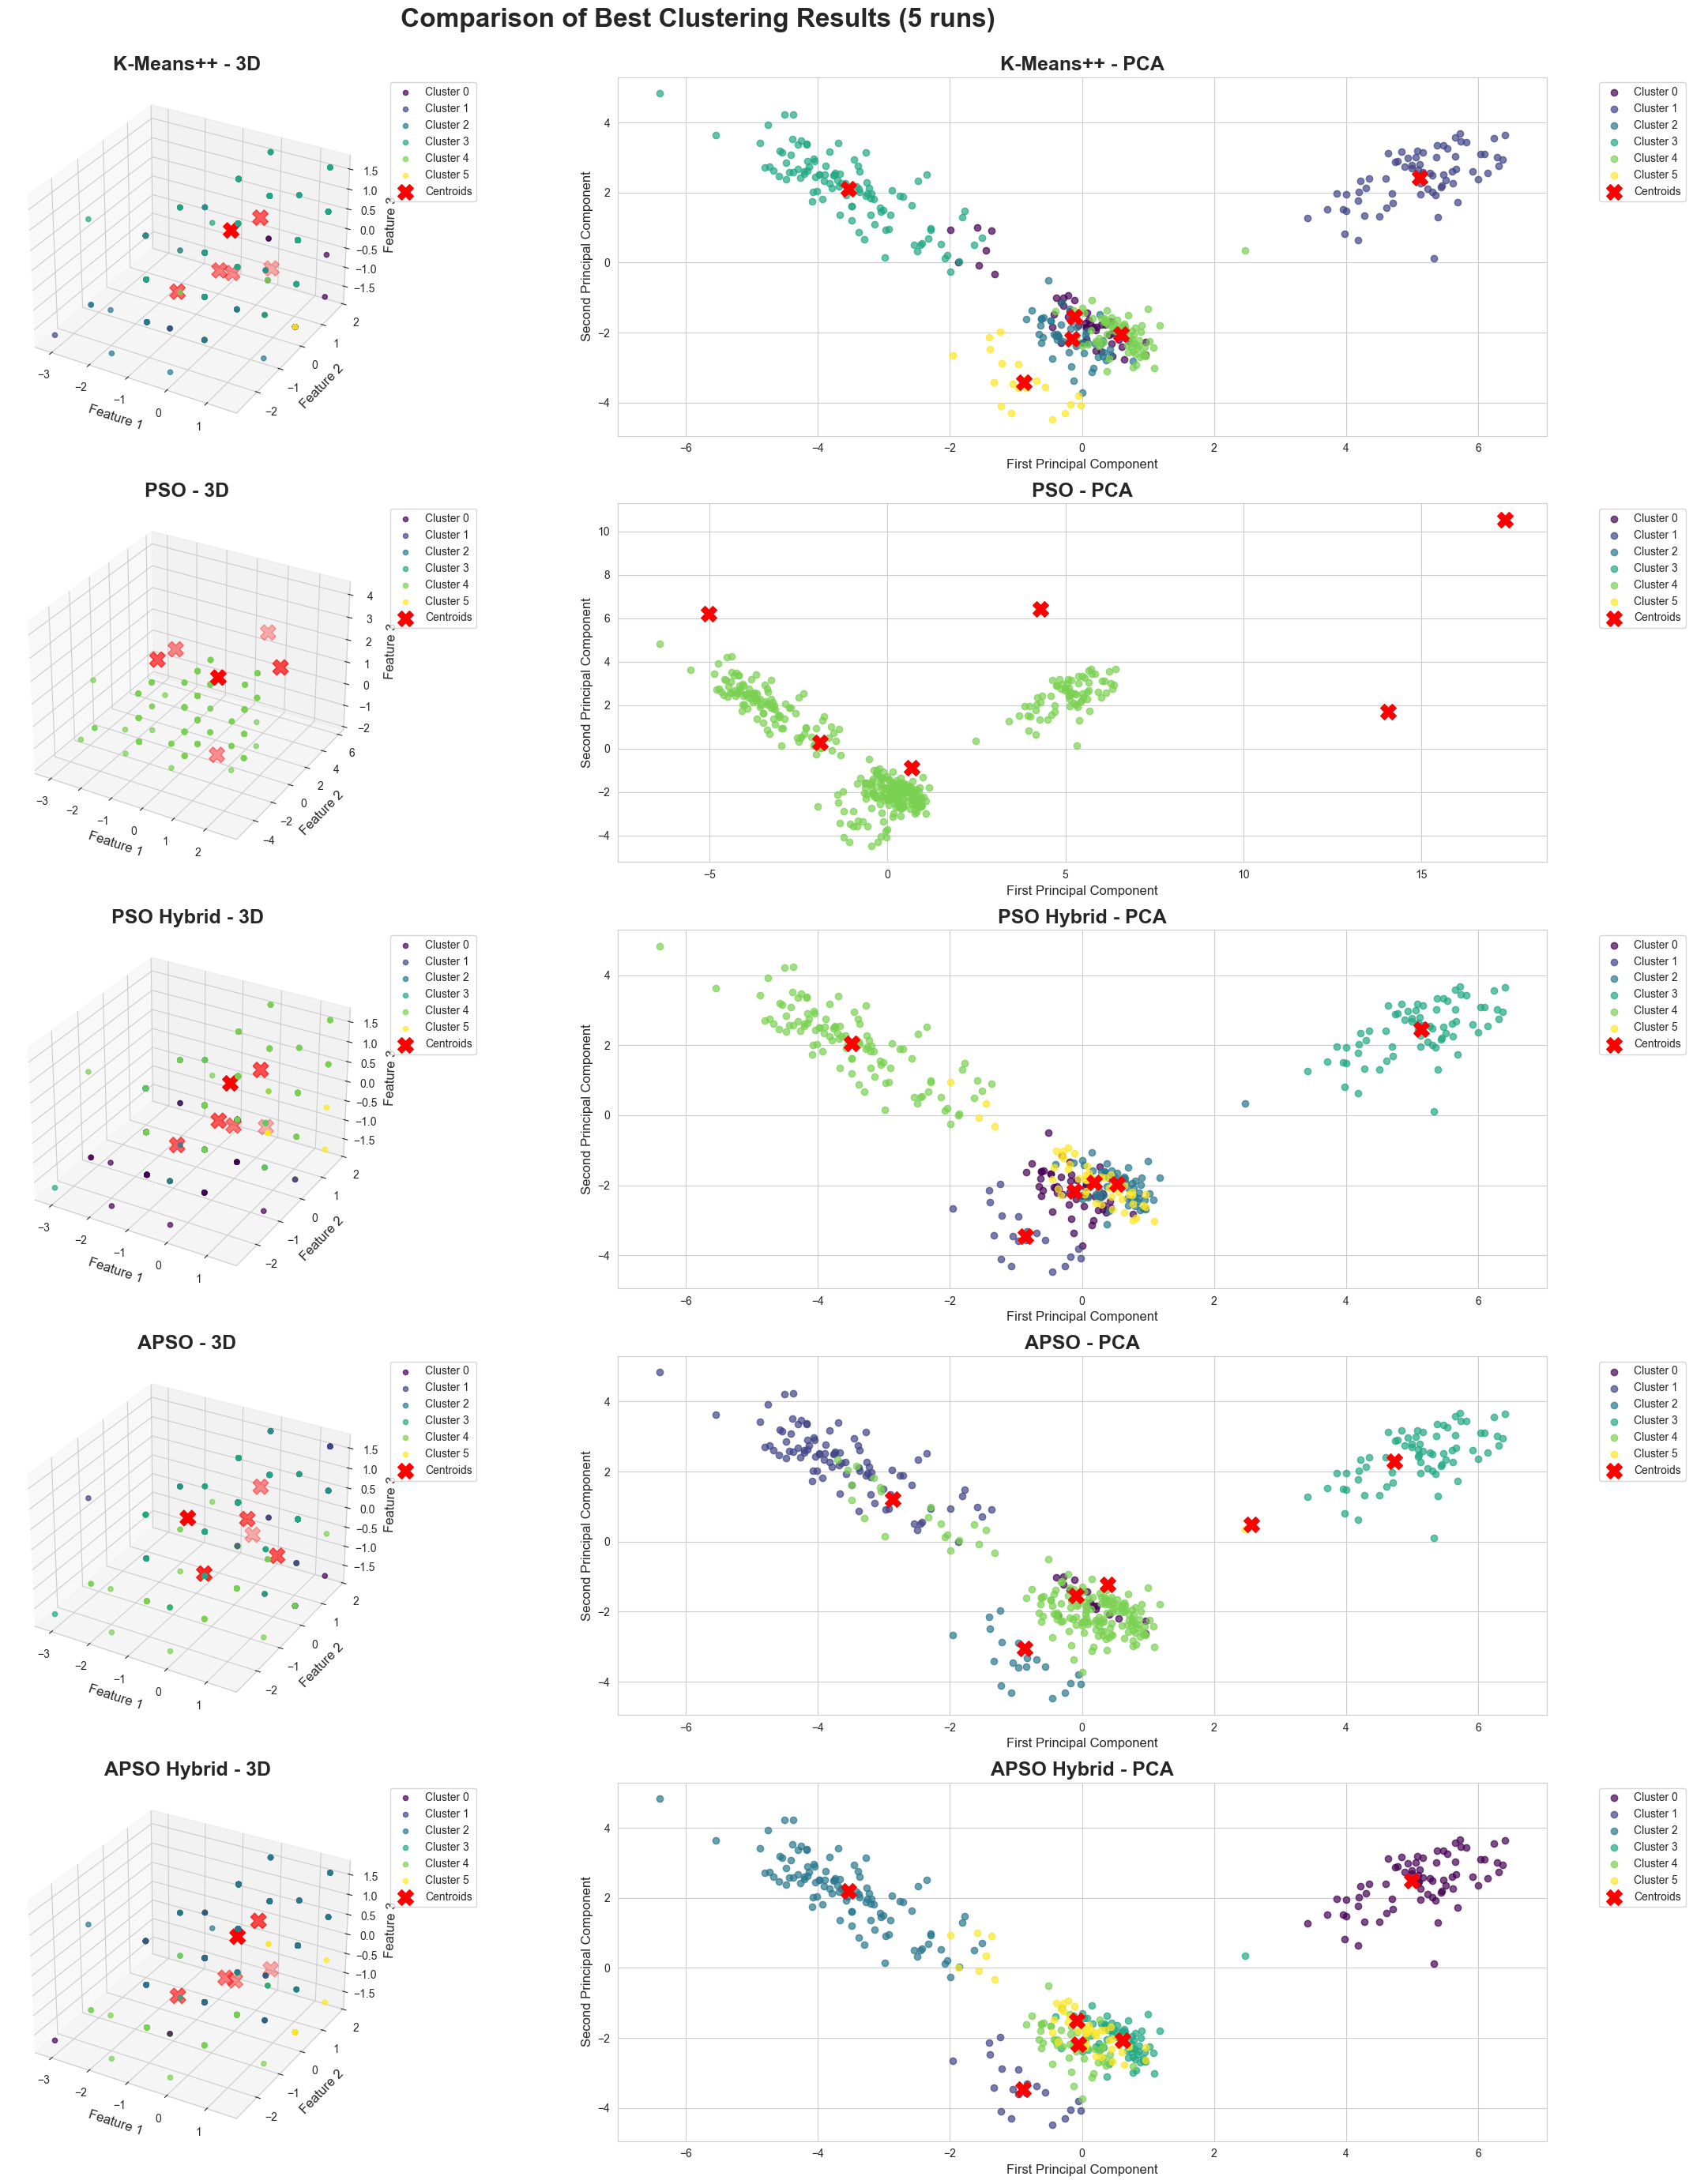

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
import numpy as np
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, pairwise_distances_argmin

def run_clustering(method, x, n_clusters=6, n_particles=50, max_iter=1000):
    if method == 'K-Means++':
        kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=np.random.randint(10000))
        kmeans.fit(x)
        labels = kmeans.labels_
        centroids = kmeans.cluster_centers_
    else:
        if 'PSO' in method:
            pso = ParticleSwarmOptimizedClustering(n_cluster=n_clusters, n_particles=n_particles, 
                                                   data=x, hybrid=('Hybrid' in method), max_iter=max_iter)
        else:  # APSO
            pso = AdaptiveParticleSwarmOptimizedClustering(n_cluster=n_clusters, n_particles=n_particles, 
                                                           data=x, hybrid=('Hybrid' in method), max_iter=max_iter)
        pso.run()
        centroids = pso.gbest_centroids
        labels = pairwise_distances_argmin(x, centroids)
    
    unique_labels = np.unique(labels)
    if len(unique_labels) < 2:
        return None, None, None, None, None  # Invalid clustering
    
    # Calculate all metrics
    silhouette = silhouette_score(x, labels)
    sse = np.sum((x - centroids[labels]) ** 2)
    quantization_error = np.mean(np.min(np.linalg.norm(x[:, np.newaxis] - centroids, axis=2), axis=1))
    
    return labels, centroids, silhouette, sse, quantization_error

def visualize_seed_clusters(data, methods, labels_dict, centroids_dict):
    sns.set_style("whitegrid")
    sns.set_palette("deep")
    
    fig = plt.figure(figsize=(25, 30))
    fig.suptitle("Comparison of Best Clustering Results (5 runs)", fontsize=24, fontweight='bold', y=0.95)
    
    color_map = plt.cm.get_cmap('viridis')(np.linspace(0, 1, 6))
    
    pca = PCA(n_components=2)
    data_2d = pca.fit_transform(data)
    
    for i, method in enumerate(methods):
        ax_3d = fig.add_subplot(5, 2, 2*i+1, projection='3d')
        ax_2d = fig.add_subplot(5, 2, 2*i+2)
        
        labels = labels_dict[method]
        centroids = centroids_dict[method]
        
        # 3D visualization (using first 3 features)
        for j in range(6):  # Assuming 2 clusters
            mask = labels == j
            ax_3d.scatter(data[mask, 0], data[mask, 1], data[mask, 2], 
                          c=[color_map[j]], label=f'Cluster {j}', alpha=0.7)
        ax_3d.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2], 
                      color='red', s=200, marker='X', label='Centroids')
        ax_3d.set_title(f'{method} - 3D', fontsize=18, fontweight='bold')
        ax_3d.set_xlabel('Feature 1', fontsize=12)
        ax_3d.set_ylabel('Feature 2', fontsize=12)
        ax_3d.set_zlabel('Feature 3', fontsize=12)
        ax_3d.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
        
        # PCA visualization
        for j in range(6):  # Assuming 2 clusters
            mask = labels == j
            ax_2d.scatter(data_2d[mask, 0], data_2d[mask, 1], 
                          c=[color_map[j]], label=f'Cluster {j}', alpha=0.7)
        centroids_2d = pca.transform(centroids)
        ax_2d.scatter(centroids_2d[:, 0], centroids_2d[:, 1], 
                      color='red', s=200, marker='X', label='Centroids')
        ax_2d.set_title(f'{method} - PCA', fontsize=18, fontweight='bold')
        ax_2d.set_xlabel('First Principal Component', fontsize=12)
        ax_2d.set_ylabel('Second Principal Component', fontsize=12)
        ax_2d.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=10)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Run clustering methods multiple times
methods = ['K-Means++', 'PSO', 'PSO Hybrid', 'APSO', 'APSO Hybrid']
n_runs = 10
max_attempts = 5

results = {method: [] for method in methods}

for method in methods:
    valid_runs = 0
    attempts = 0
    while valid_runs < n_runs and attempts < max_attempts:
        cluster_results = run_clustering(method, x)
        if cluster_results[0] is not None:  # Check if labels exist
            results[method].append(cluster_results)
            valid_runs += 1
        attempts += 1
    
    if valid_runs < n_runs:
        print(f"Warning: {method} only produced {valid_runs} valid clusterings out of {attempts} attempts.")

# Select best run for each method using all metrics
labels_dict = {}
centroids_dict = {}

for method in methods:
    if results[method]:
        # Extract metrics for all runs
        silhouettes = np.array([run[2] for run in results[method]])
        sses = np.array([run[3] for run in results[method]])
        quantization_errors = np.array([run[4] for run in results[method]])
        
        # Normalize metrics to [0,1] range
        norm_silhouette = (silhouettes - np.min(silhouettes)) / (np.max(silhouettes) - np.min(silhouettes) + 1e-10)
        norm_sse = (sses - np.min(sses)) / (np.max(sses) - np.min(sses) + 1e-10)
        norm_quantization = (quantization_errors - np.min(quantization_errors)) / (np.max(quantization_errors) - np.min(quantization_errors) + 1e-10)
        
        # Combined score (higher is better)
        combined_scores = norm_silhouette + (1 - norm_sse) + (1 - norm_quantization)
        best_idx = np.argmax(combined_scores)
        
        # Store best results
        labels_dict[method] = results[method][best_idx][0]
        centroids_dict[method] = results[method][best_idx][1]
        
        # Print all metrics for best run
        print(f"\n{method} - Best Run Metrics:")
        print(f"Silhouette Score: {results[method][best_idx][2]:.4f}")
        print(f"SSE: {results[method][best_idx][3]:.4f}")
        print(f"Quantization Error: {results[method][best_idx][4]:.4f}")
    else:
        print(f"{method} failed to produce any valid clusterings.")

# Visualize best clusters for methods with valid results
valid_methods = [method for method in methods if method in labels_dict]
if valid_methods:
    visualize_seed_clusters(x, valid_methods, labels_dict, centroids_dict)
else:
    print("No valid clustering results to visualize.")

### Silhouette Study 📊



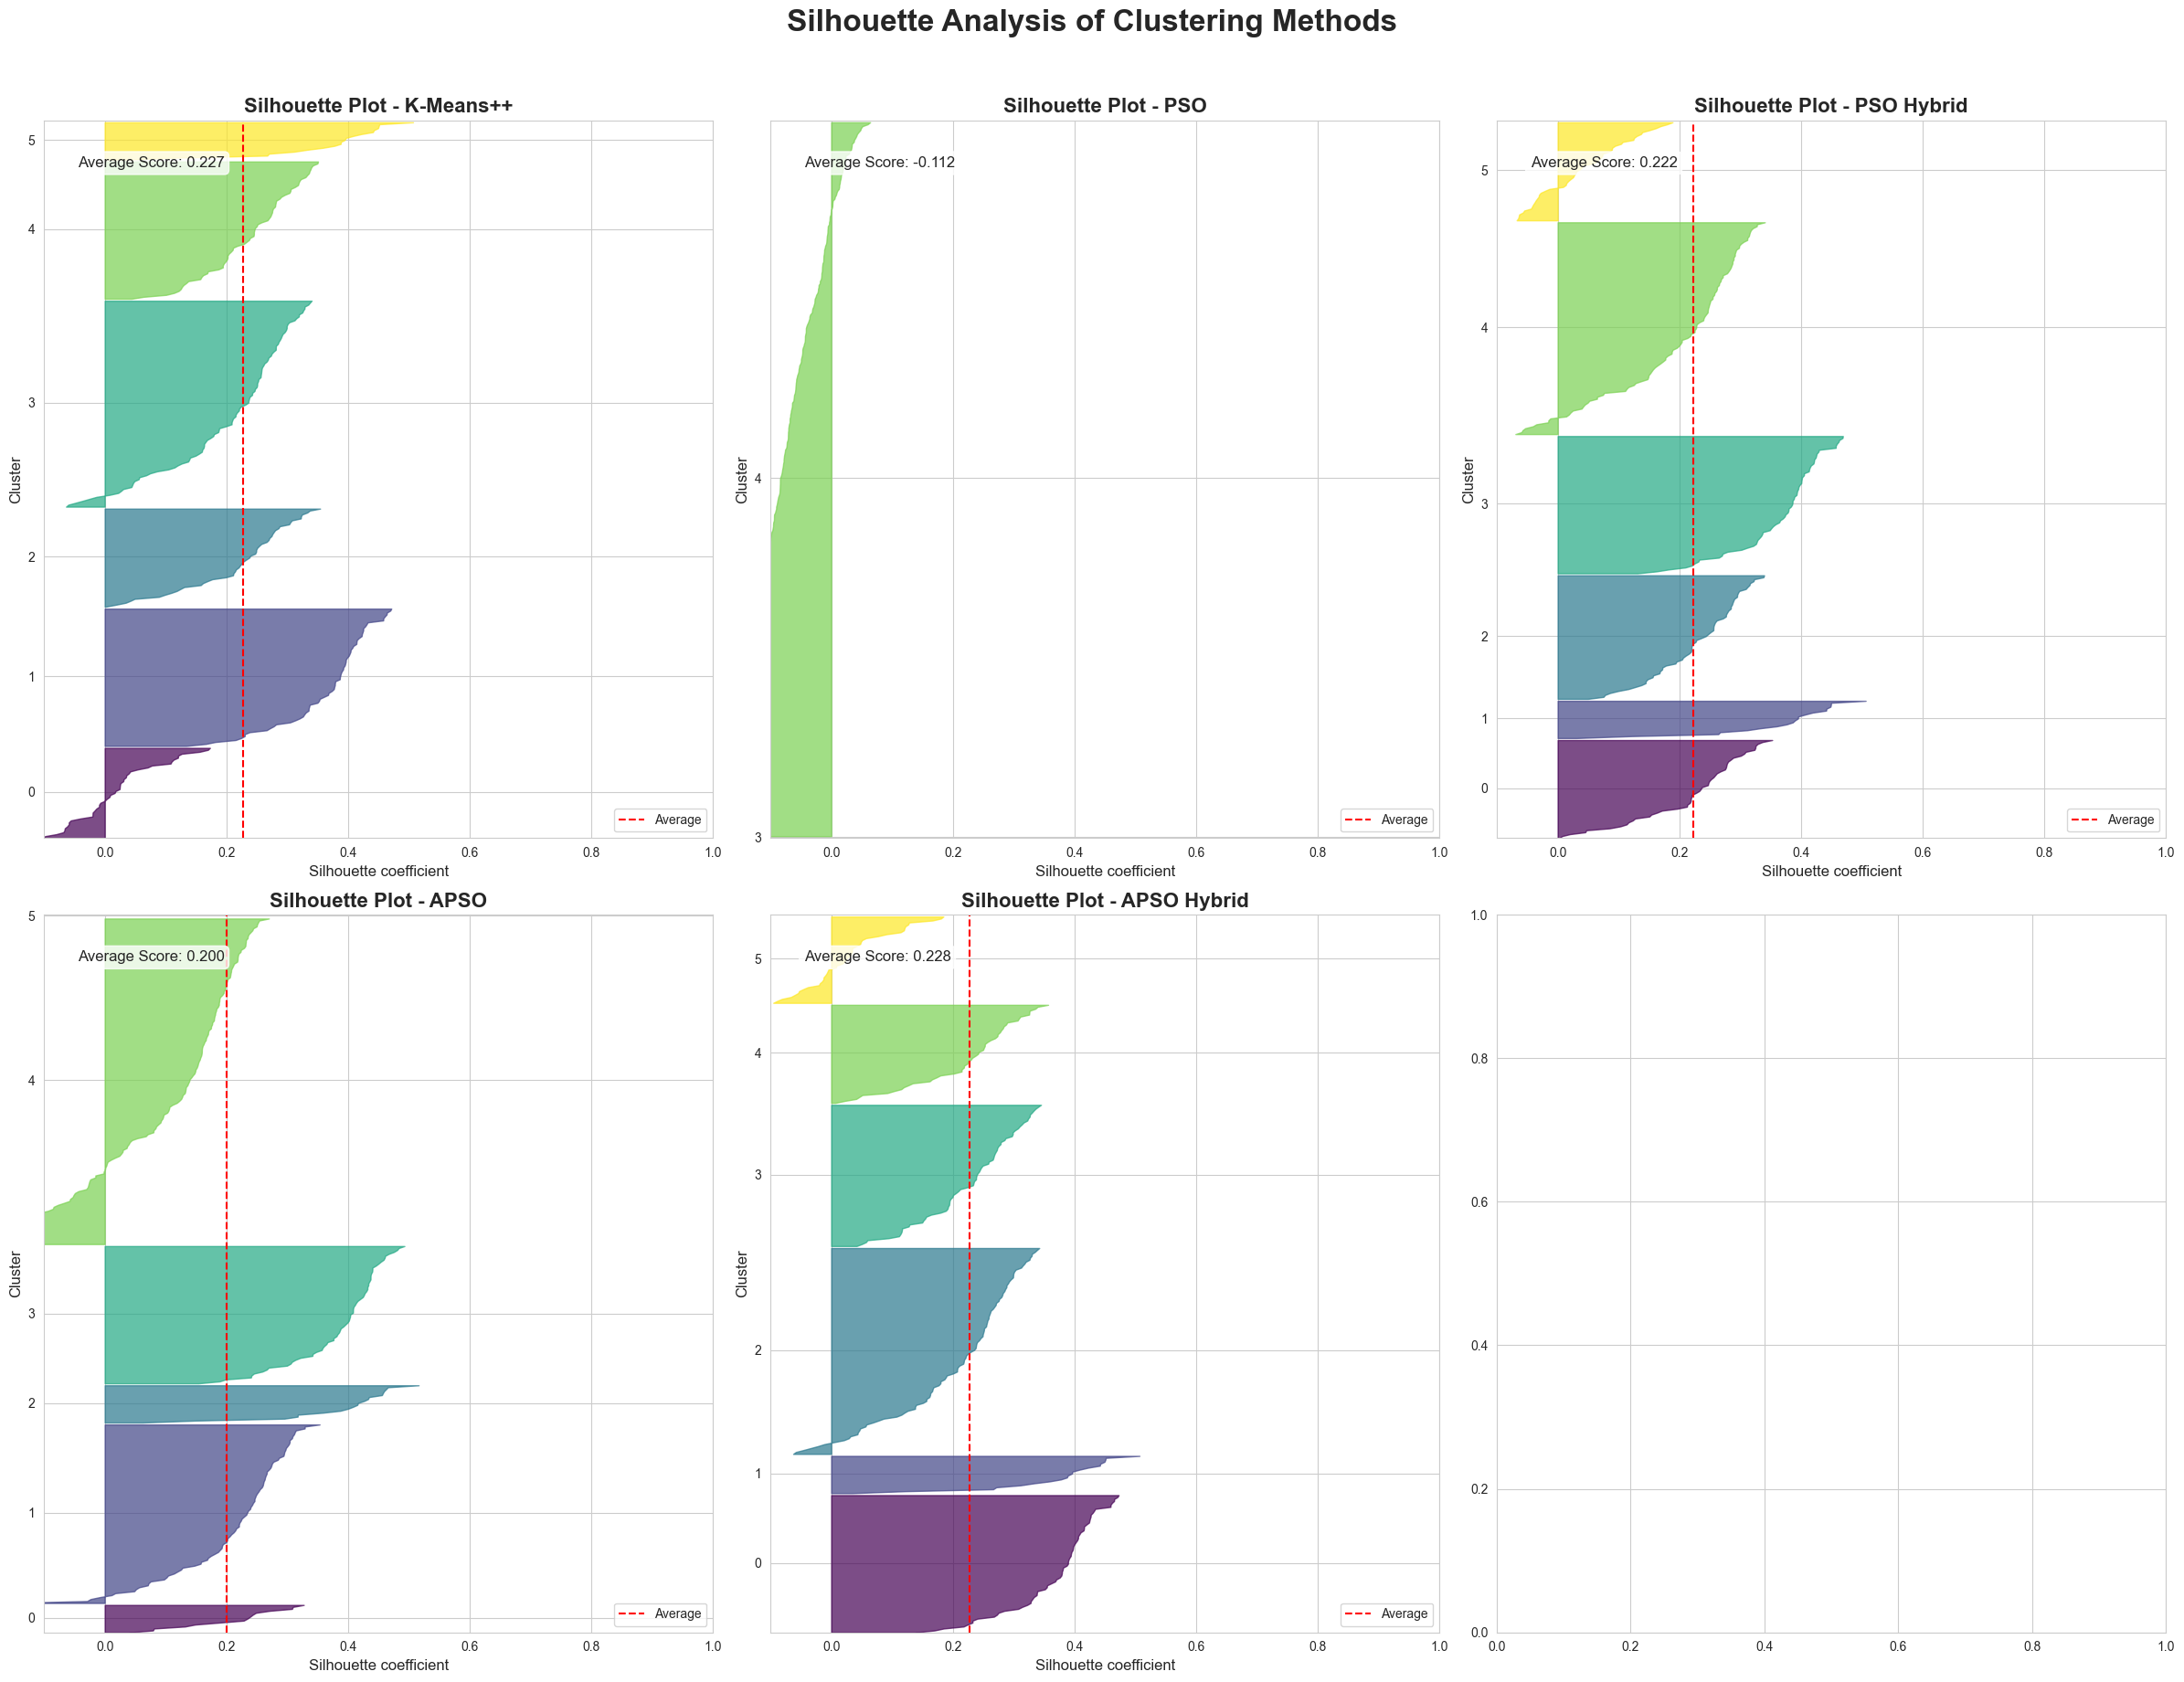

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import silhouette_samples, silhouette_score

def plot_enhanced_silhouette(data, labels_dict):
    fig, axes = plt.subplots(2, 3, figsize=(24, 18))
    axes = axes.flatten()
    
    sns.set_style("whitegrid")
    plt.suptitle("Silhouette Analysis of Clustering Methods", fontsize=24, fontweight='bold', y=1.02)

    colors = plt.cm.viridis(np.linspace(0, 1, 6))

    for i, (method, labels) in enumerate(labels_dict.items()):
        unique_labels = np.unique(labels)
        if len(unique_labels) < 2:
            axes[i].text(0.5, 0.5, f"{method}\nOnly one cluster found", 
                         ha='center', va='center', fontsize=16)
            axes[i].set_title(f'{method} - Invalid Clustering', fontsize=16, fontweight='bold')
            continue

        silhouette_vals = silhouette_samples(data, labels)
        avg_score = silhouette_score(data, labels)
        
        y_lower, y_upper = 0, 0
        yticks = []
        for cluster in unique_labels:
            cluster_silhouette_vals = silhouette_vals[labels == cluster]
            cluster_silhouette_vals.sort()
            size_cluster = len(cluster_silhouette_vals)
            y_upper += size_cluster
            
            color = colors[cluster % len(colors)]
            axes[i].fill_betweenx(np.arange(y_lower, y_upper), 0, cluster_silhouette_vals, 
                                  facecolor=color, edgecolor=color, alpha=0.7)
            
            yticks.append((y_lower + y_upper) / 2)
            y_lower += size_cluster

        axes[i].axvline(x=avg_score, color="red", linestyle="--", label='Average')
        axes[i].set_title(f'Silhouette Plot - {method}', fontsize=16, fontweight='bold')
        axes[i].set_xlabel('Silhouette coefficient', fontsize=12)
        axes[i].set_ylabel('Cluster', fontsize=12)
        axes[i].set_yticks(yticks)
        axes[i].set_yticklabels(unique_labels)
        axes[i].set_xlim([-0.1, 1])
        axes[i].set_ylim(0, len(silhouette_vals))
        
        # Add text annotations
        axes[i].text(0.05, 0.95, f'Average Score: {avg_score:.3f}', 
                     transform=axes[i].transAxes, fontsize=12, 
                     verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Add a legend
        axes[i].legend(loc='lower right', fontsize=10)

    plt.tight_layout()
    plt.show()

# Usage
plot_enhanced_silhouette(x, labels_dict)

### t-SNE Analysis 🔍


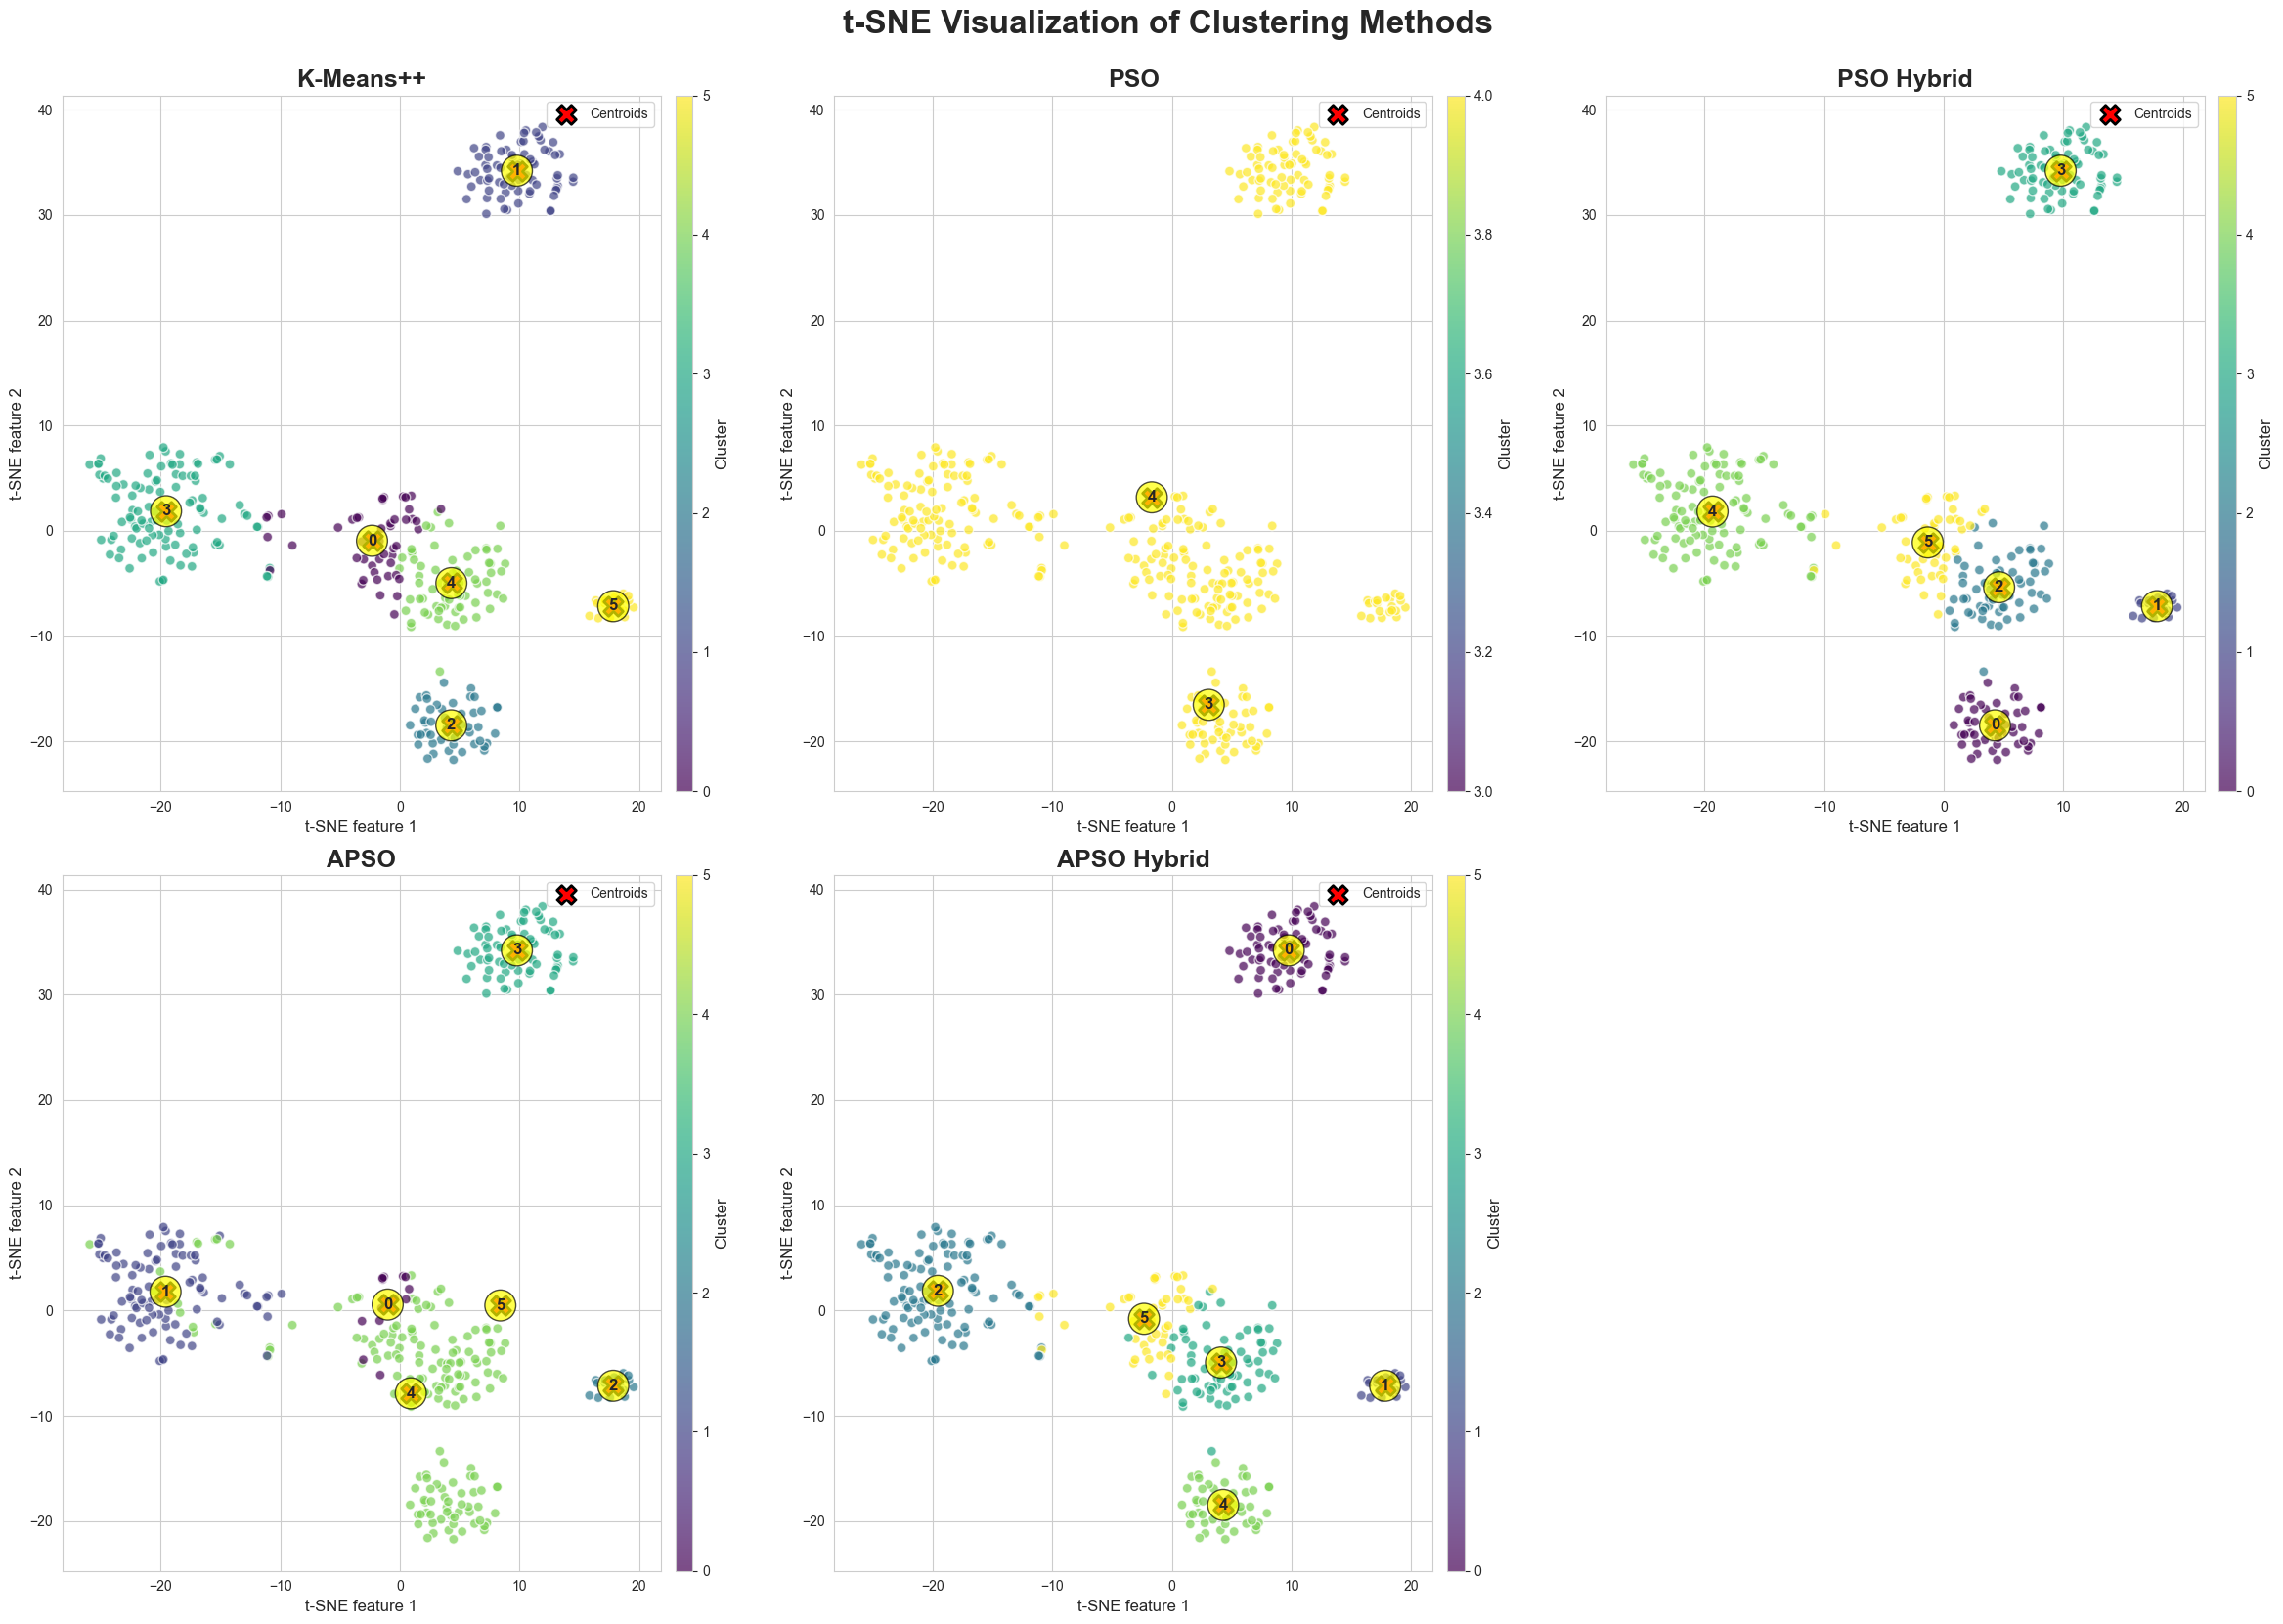

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.manifold import TSNE

def plot_enhanced_tsne(data, labels_dict, methods):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(data)
    
    fig = plt.figure(figsize=(24, 18))
    fig.suptitle("t-SNE Visualization of Clustering Methods", fontsize=24, fontweight='bold', y=0.95)
    
    sns.set_style("whitegrid")
    sns.set_palette("deep")
    
    for i, method in enumerate(methods):
        ax = fig.add_subplot(2, 3, i+1)
        
        scatter = ax.scatter(tsne_results[:, 0], tsne_results[:, 1], 
                             c=labels_dict[method], cmap='viridis', 
                             alpha=0.7, s=50, edgecolors='w')
        
        ax.set_title(f'{method}', fontsize=18, fontweight='bold')
        ax.set_xlabel('t-SNE feature 1', fontsize=12)
        ax.set_ylabel('t-SNE feature 2', fontsize=12)
        
        # Add colorbar
        cbar = plt.colorbar(scatter, ax=ax, aspect=40, pad=0.02)
        cbar.set_label('Cluster', fontsize=12)
        
        # Add cluster centroids
        unique_labels = np.unique(labels_dict[method])
        centroids = np.array([np.mean(tsne_results[labels_dict[method] == label], axis=0) 
                              for label in unique_labels])
        ax.scatter(centroids[:, 0], centroids[:, 1], 
                   marker='X', s=200, linewidths=2, 
                   c='red', edgecolors='k')
        
        # Add cluster labels
        for label, centroid in zip(unique_labels, centroids):
            ax.annotate(f'{label}', centroid, fontsize=12, fontweight='bold',
                        ha='center', va='center',
                        bbox=dict(boxstyle='circle,pad=0.5', fc='yellow', ec='k', alpha=0.7),
                        xytext=(0, 0), textcoords='offset points')
        
        # Add legend for centroids
        ax.scatter([], [], marker='X', s=200, linewidths=2, c='red', edgecolors='k', label='Centroids')
        ax.legend(loc='best', fontsize=10)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Usage
plot_enhanced_tsne(x, labels_dict, methods)

### Feature Analysis 🔬


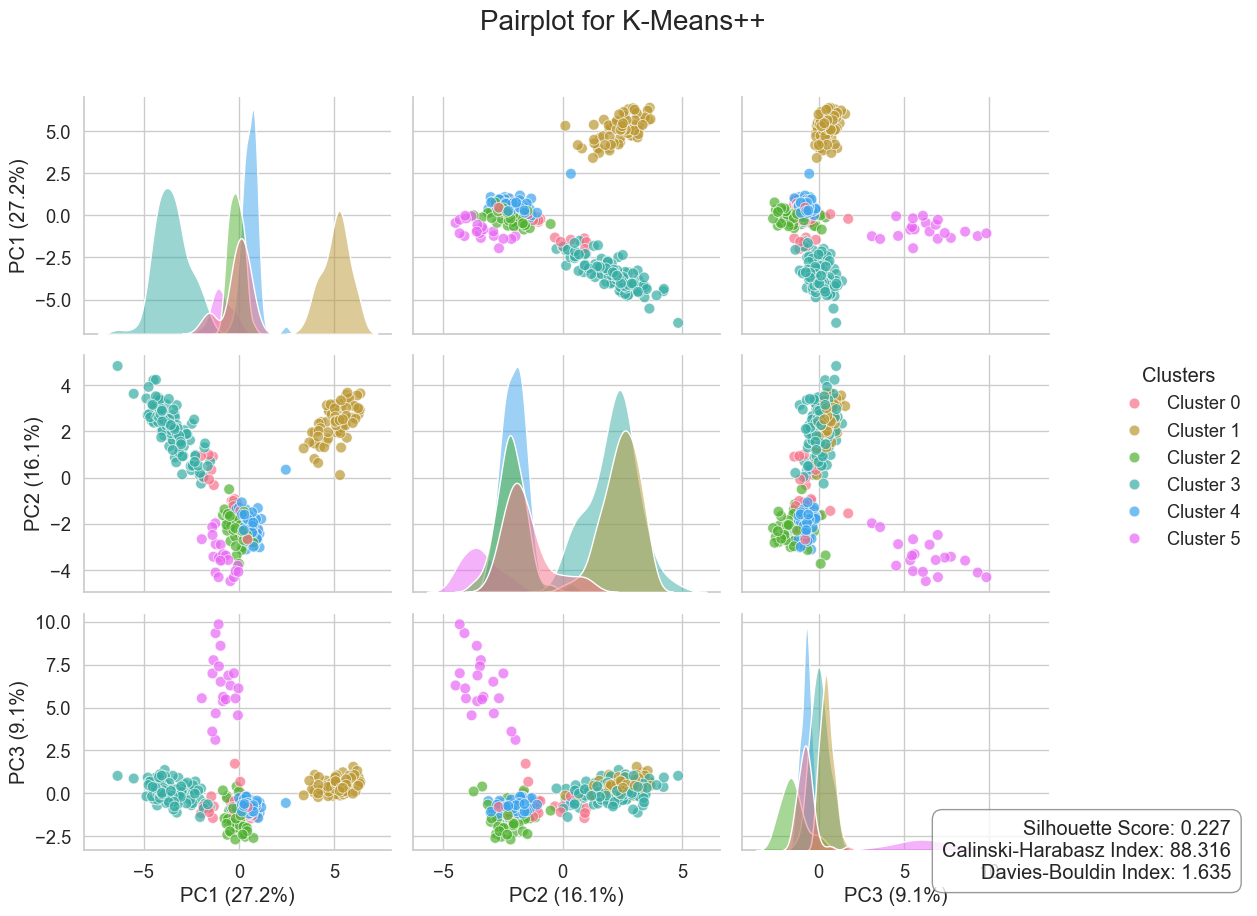

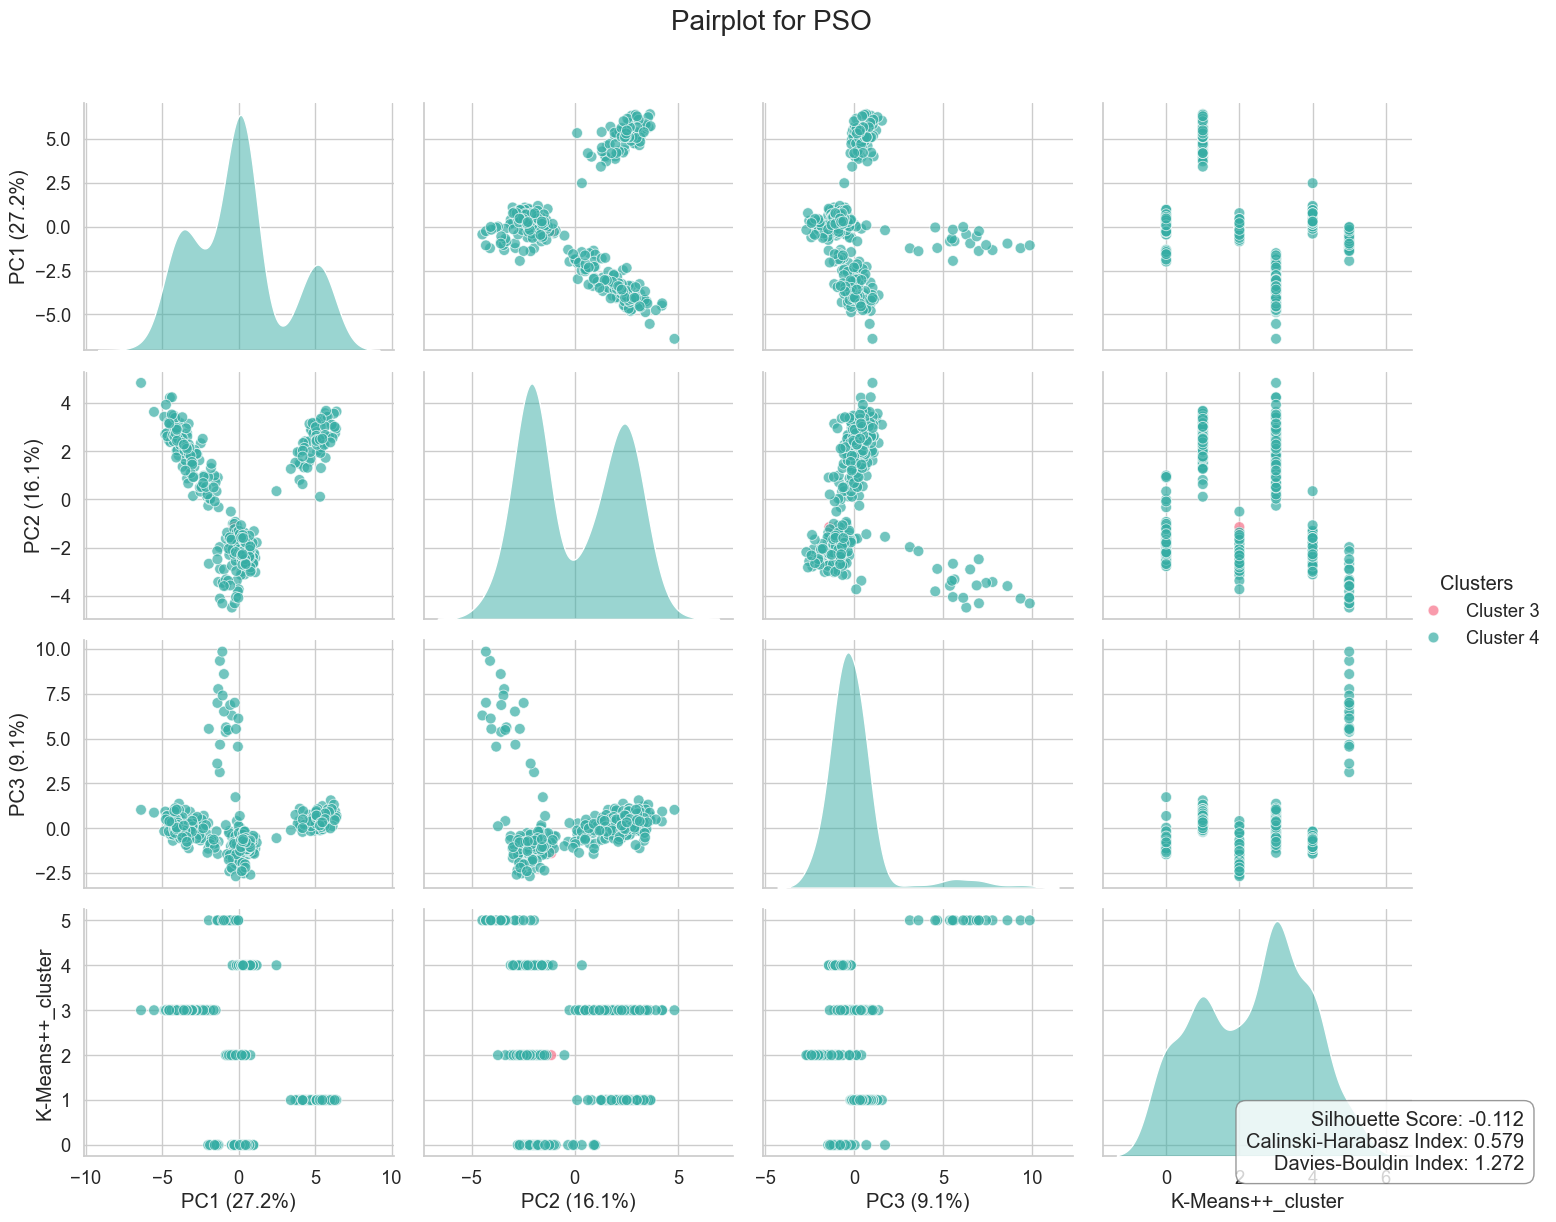

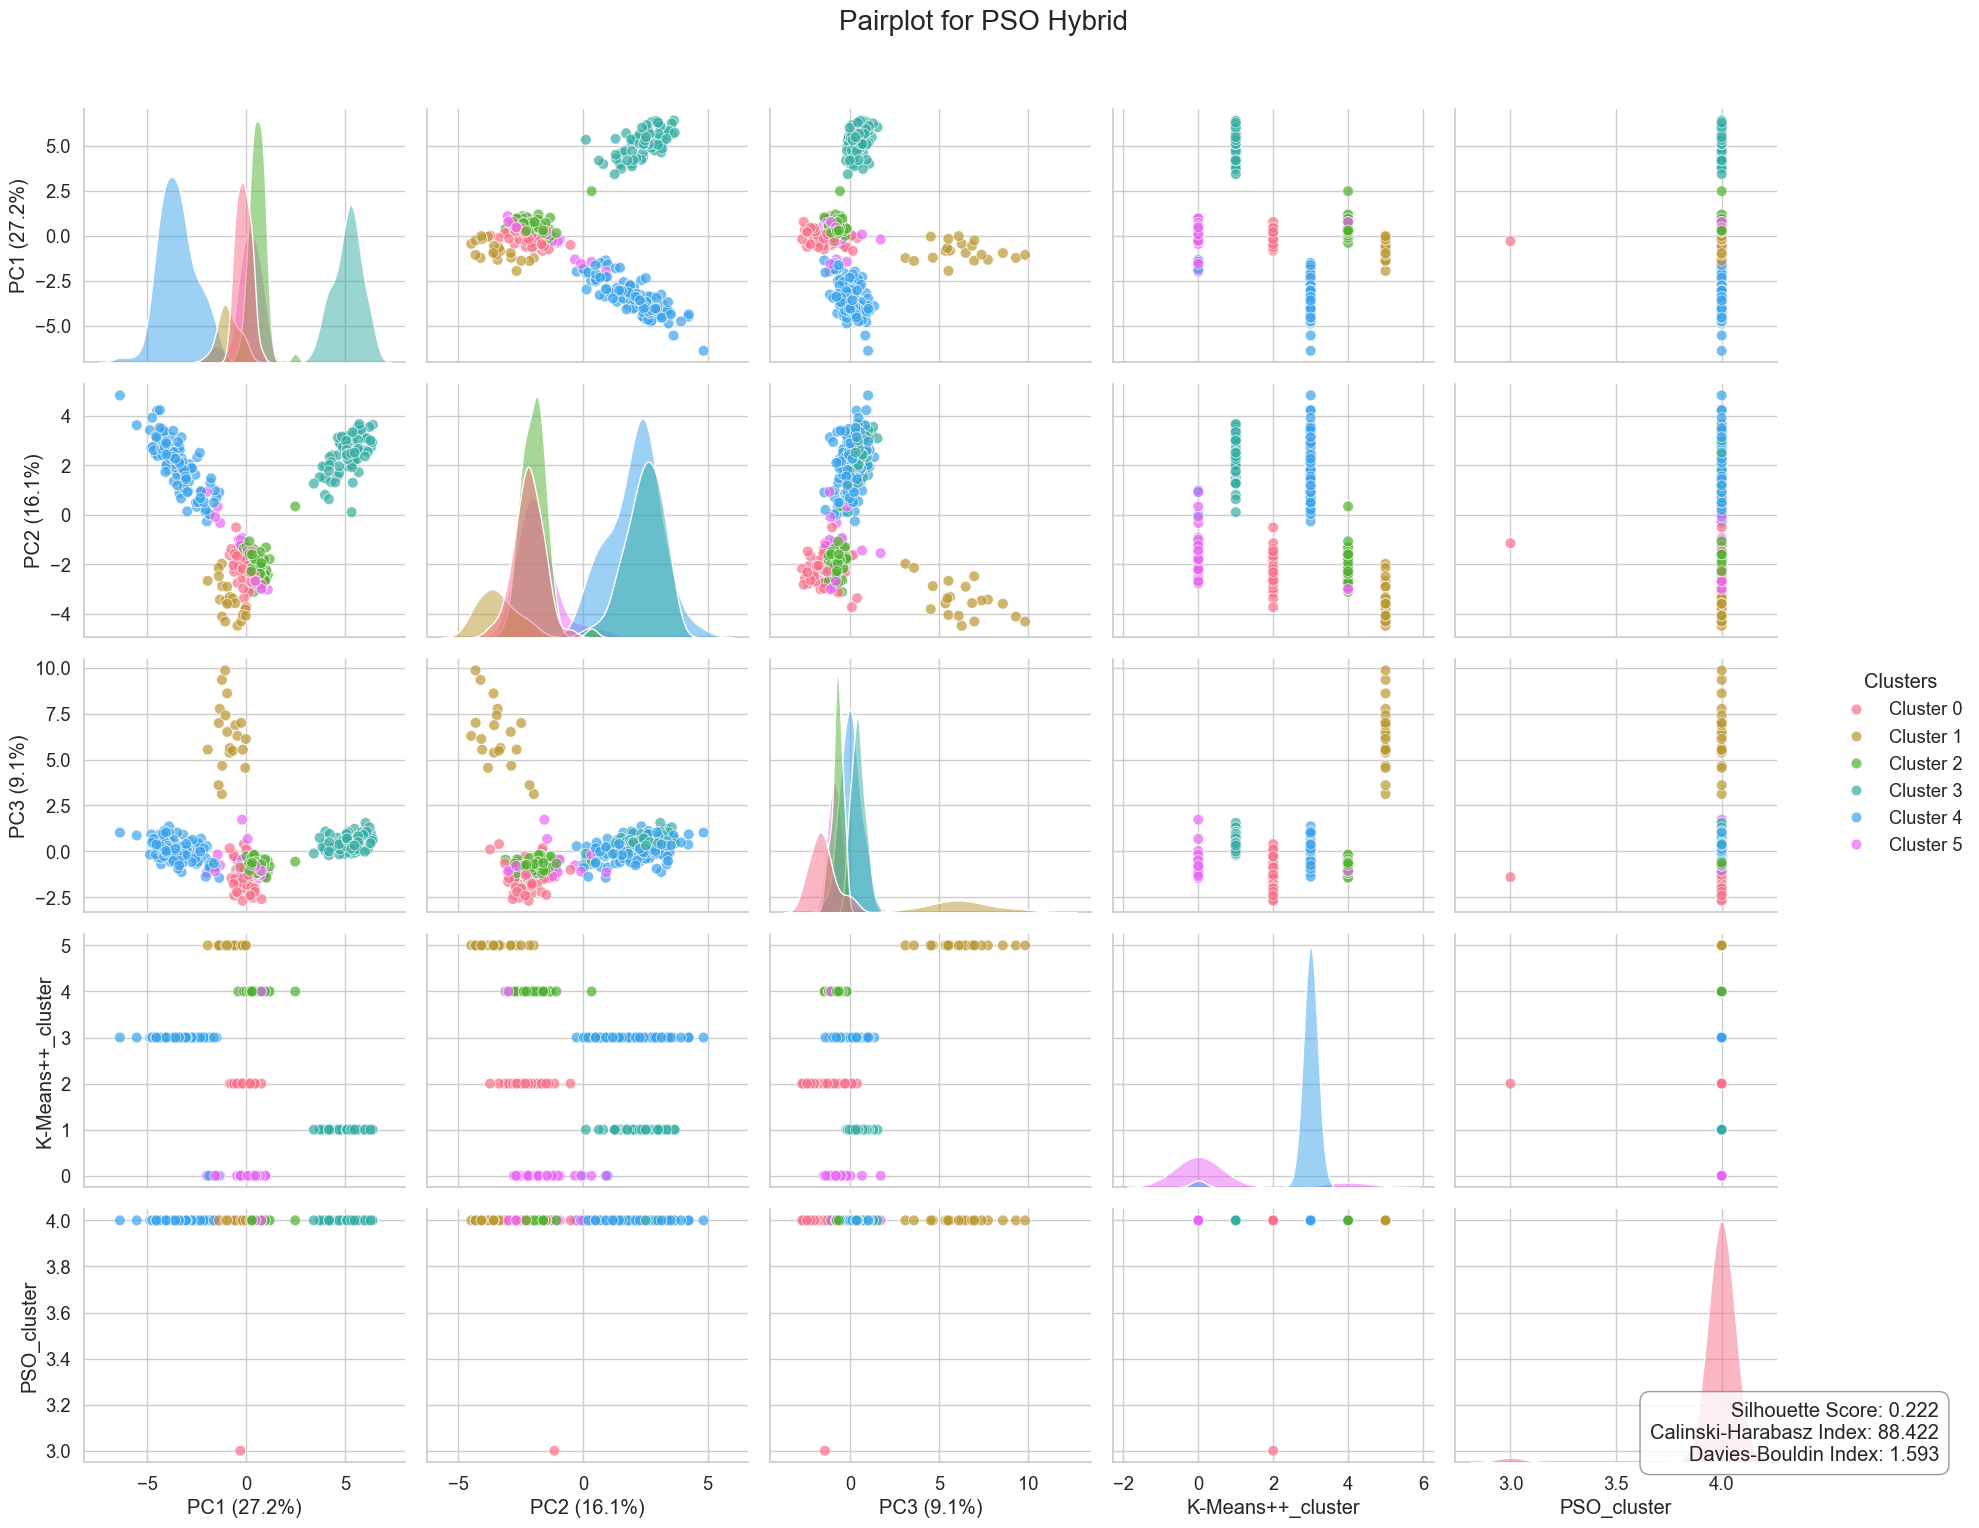

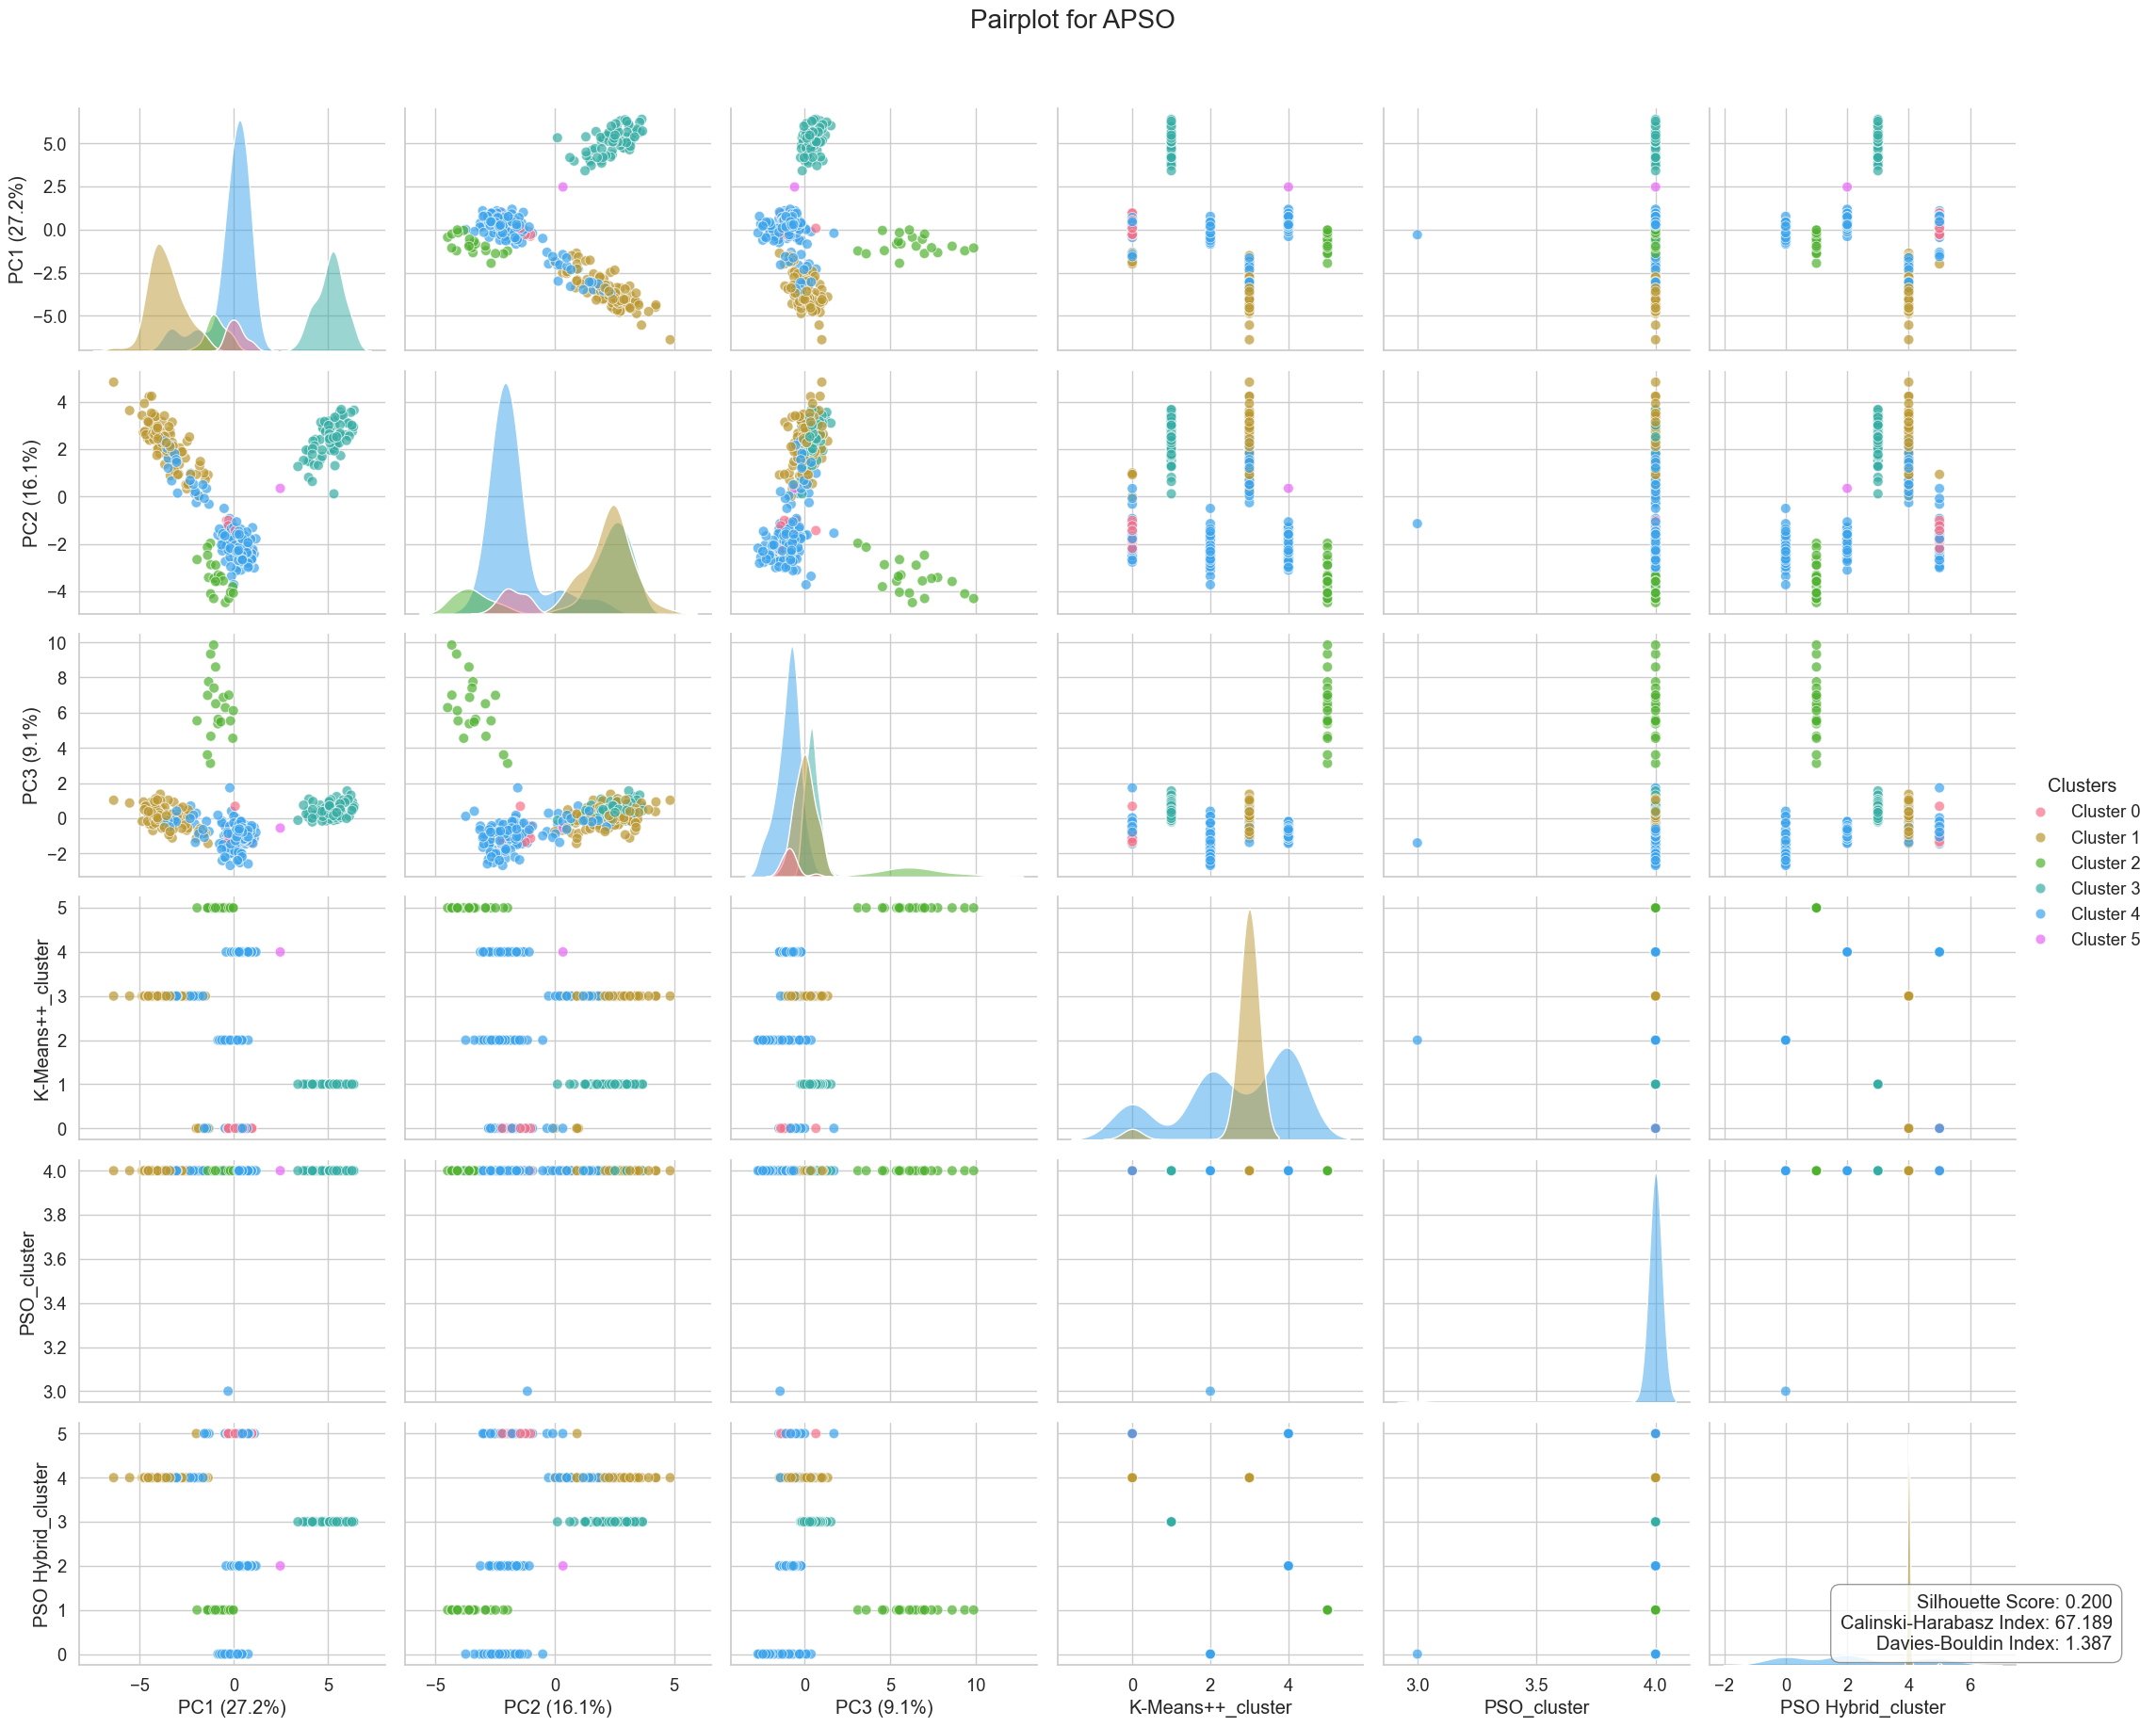

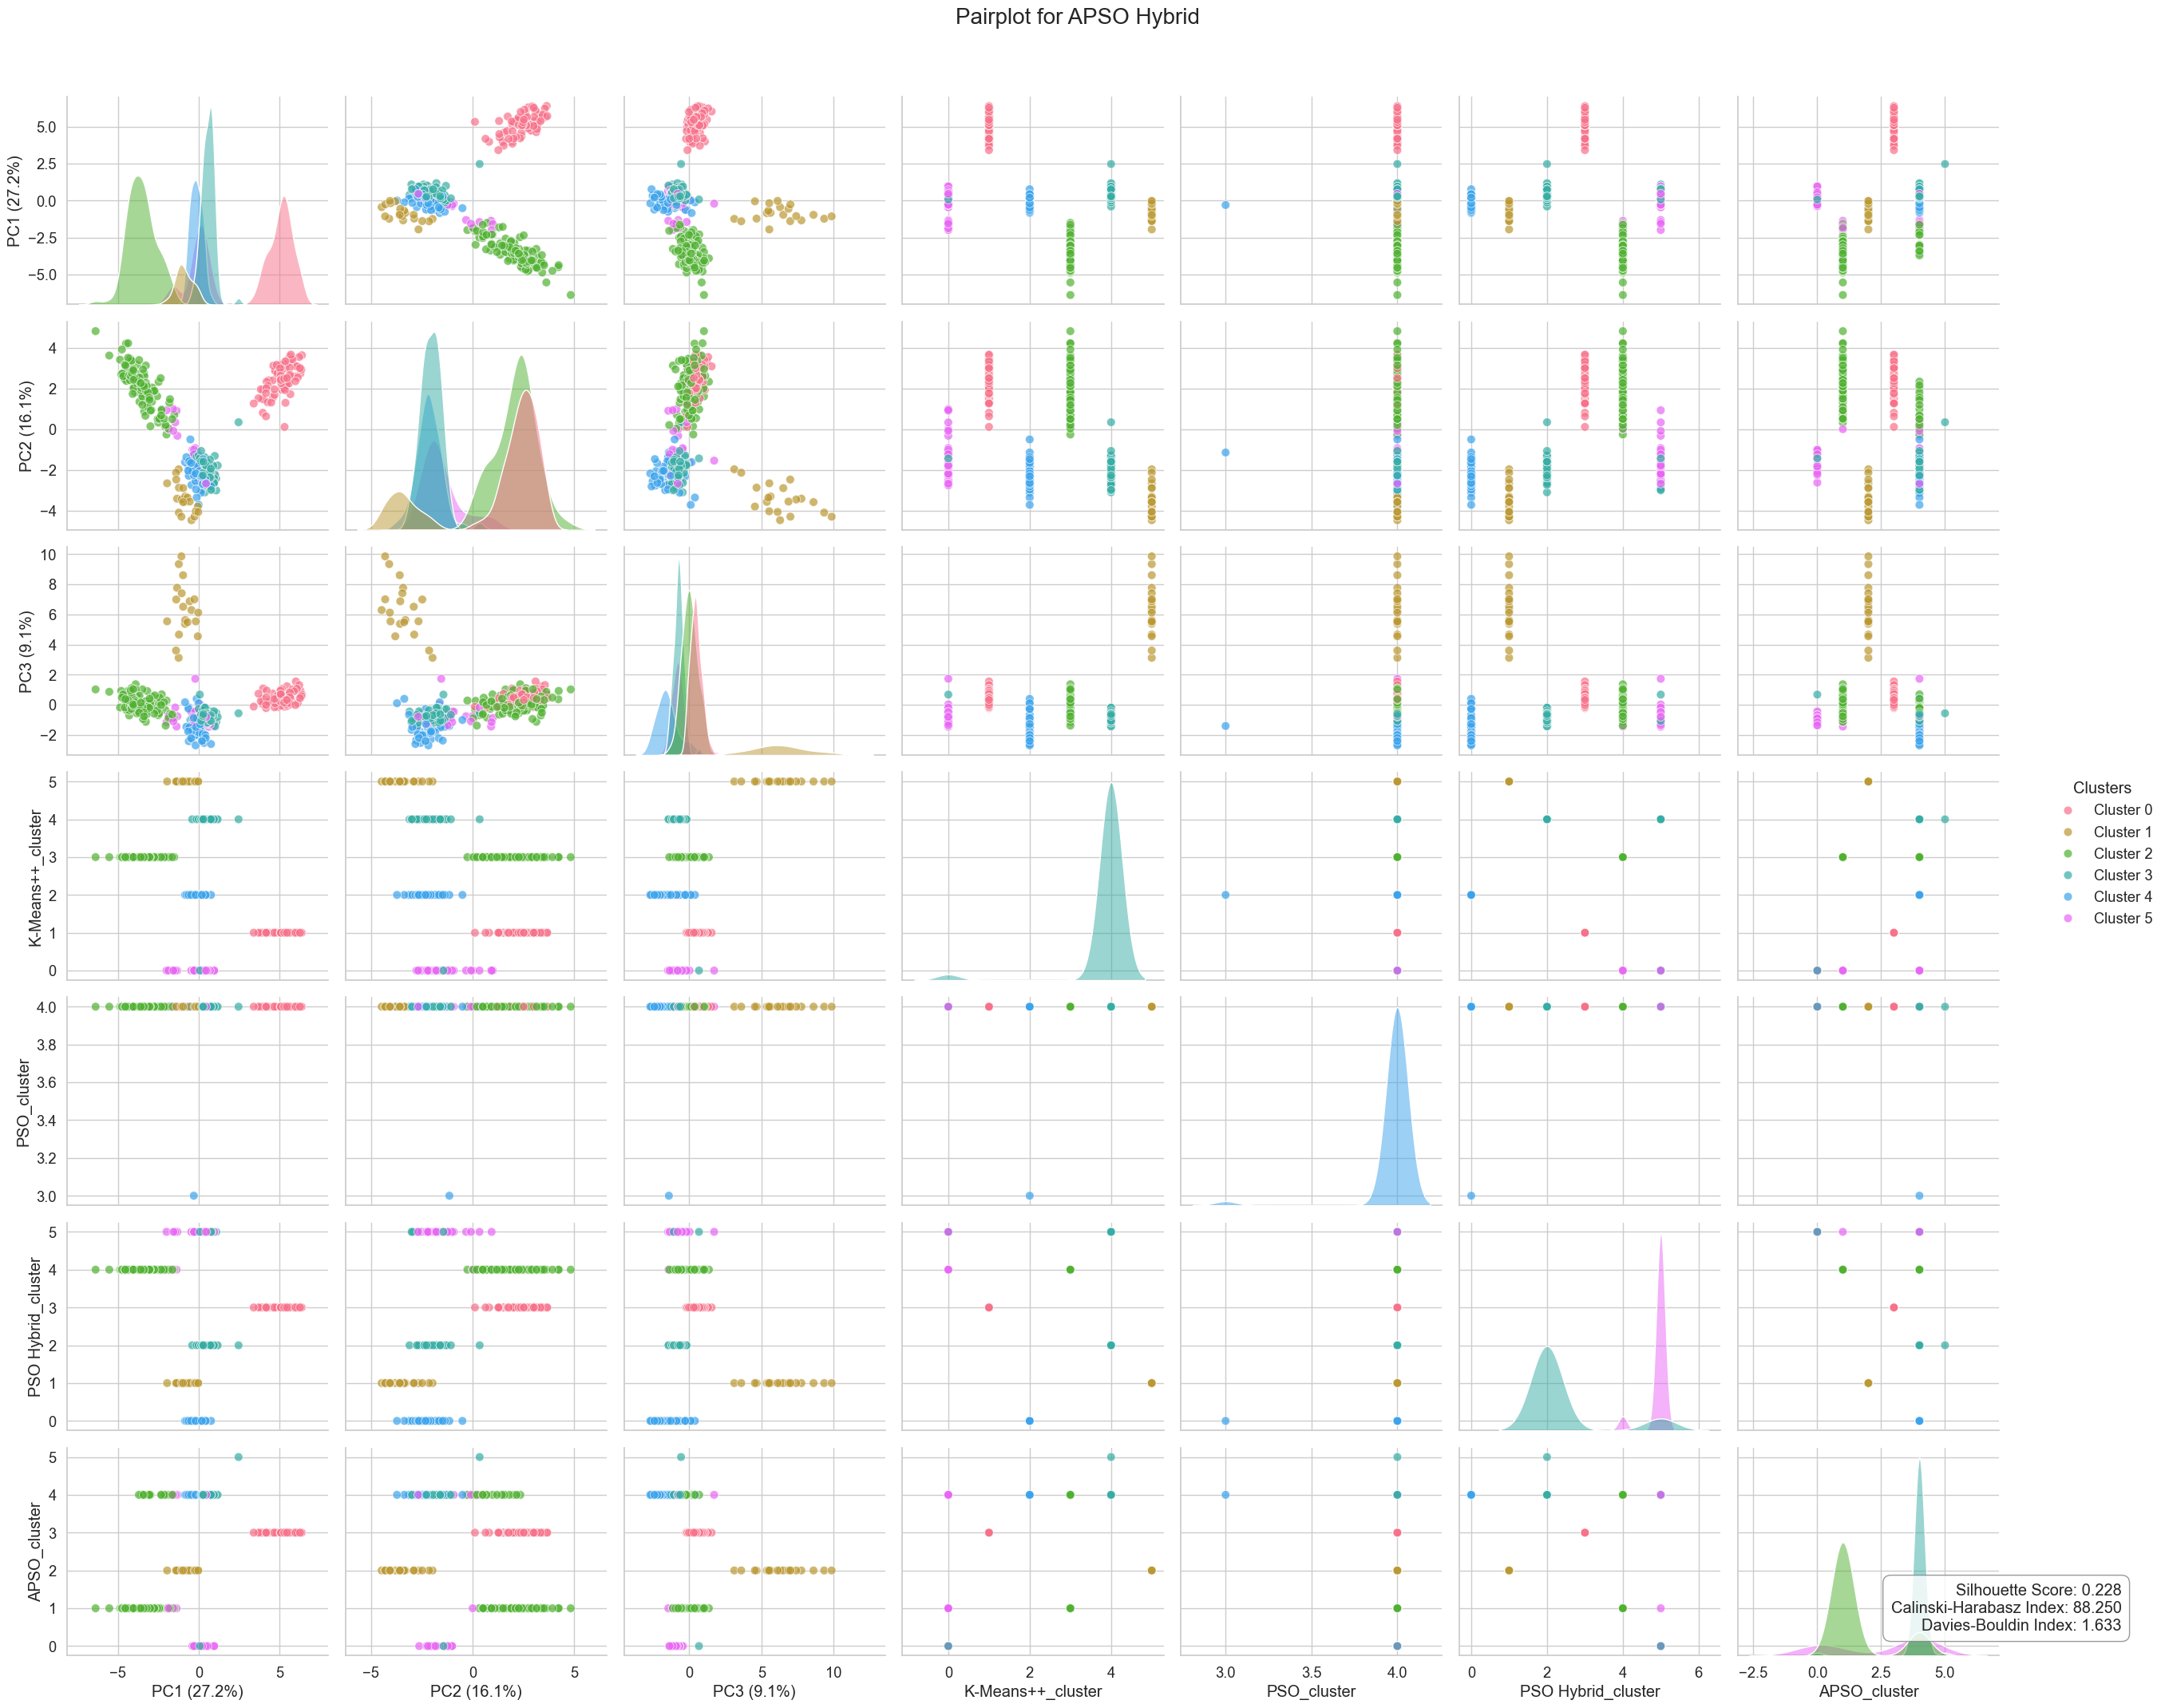

C:\Users\shiva\AppData\Local\Temp\ipykernel_16176\4035480577.py:98: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
C:\Users\shiva\AppData\Local\Temp\ipykernel_16176\4035480577.py:98: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')


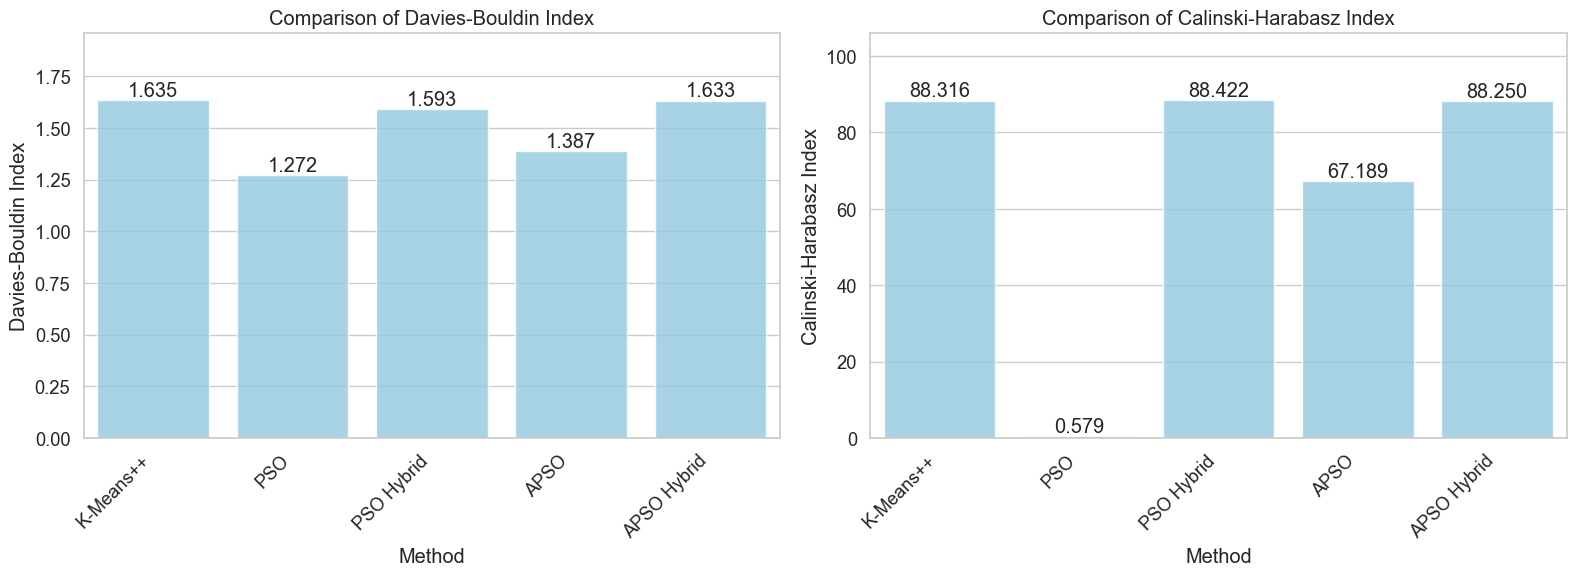

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import re

def plot_enhanced_pairplots(data, labels_dict, methods):
    # Perform PCA
    pca = PCA(n_components=min(3, data.shape[1]))
    x_pca = pca.fit_transform(data)
    df_pca = pd.DataFrame(x_pca, columns=[f'PC{i+1}' for i in range(x_pca.shape[1])])
    
    # Calculate explained variance
    explained_variance = pca.explained_variance_ratio_ * 100

    # Store the metrics for later plotting
    metrics_dict = {method: {} for method in methods}

    for method in methods:
        df_pca[f'{method}_cluster'] = labels_dict[method]
        
        # Check if there's only one cluster
        if len(np.unique(labels_dict[method])) < 2:
            print(f"Warning: {method} produced only one cluster. Skipping this method.")
            continue
        
        # Set up the plot style
        sns.set(style="whitegrid", font_scale=1.2)
        colors = sns.color_palette("husl", n_colors=len(np.unique(labels_dict[method])))
        
        # Create the pairplot
        g = sns.pairplot(df_pca, hue=f'{method}_cluster', palette=colors, 
                         plot_kws={'alpha': 0.7, 's': 60, 'edgecolor': 'w'},
                         diag_kws={'alpha': 0.5, 'edgecolor': 'w'},
                         height=3, aspect=1.2)
        
        # Enhance the plot
        g.fig.suptitle(f'Pairplot for {method}', fontsize=20, y=1.02)
        
        # Add explained variance to axis labels
        for ax in g.axes.flat:
            if ax is not None:
                xlabel = ax.get_xlabel()
                ylabel = ax.get_ylabel()
                if xlabel:
                    pc_num = re.search(r'PC(\d+)', xlabel)
                    if pc_num:
                        pc_index = int(pc_num.group(1)) - 1
                        ax.set_xlabel(f'{xlabel} ({explained_variance[pc_index]:.1f}%)')
                if ylabel:
                    pc_num = re.search(r'PC(\d+)', ylabel)
                    if pc_num:
                        pc_index = int(pc_num.group(1)) - 1
                        ax.set_ylabel(f'{ylabel} ({explained_variance[pc_index]:.1f}%)')
        
        # Adjust legend
        g._legend.set_title('Clusters')
        for t in g._legend.texts:
            t.set_text(f'Cluster {t.get_text()}')
        
        # Calculate and store the metrics
        try:
            metrics_dict[method]['Silhouette Score'] = silhouette_score(data, labels_dict[method])
            metrics_dict[method]['Calinski-Harabasz Index'] = calinski_harabasz_score(data, labels_dict[method])
            metrics_dict[method]['Davies-Bouldin Index'] = davies_bouldin_score(data, labels_dict[method])
            
            metrics_text = (f"Silhouette Score: {metrics_dict[method]['Silhouette Score']:.3f}\n"
                            f"Calinski-Harabasz Index: {metrics_dict[method]['Calinski-Harabasz Index']:.3f}\n"
                            f"Davies-Bouldin Index: {metrics_dict[method]['Davies-Bouldin Index']:.3f}")
        except ValueError as e:
            metrics_text = f"Error calculating metrics: {str(e)}"
        
        plt.text(0.98, 0.05, metrics_text, transform=g.fig.transFigure, 
                 horizontalalignment='right', verticalalignment='bottom',
                 bbox=dict(facecolor='white', alpha=0.8, edgecolor='gray', boxstyle='round,pad=0.5'))
        
        plt.tight_layout()
        plt.show()

    return metrics_dict

def plot_clustering_indices(metrics_dict):
    indices = ['Davies-Bouldin Index', 'Calinski-Harabasz Index']
    methods = list(metrics_dict.keys())
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    for i, index in enumerate(indices):
        values = [metrics_dict[method][index] for method in methods]
        
        # Create the bar plot
        sns.barplot(x=methods, y=values, ax=axes[i], capsize=0.1, color='skyblue', alpha=0.8)
        
        axes[i].set_title(f'Comparison of {index}')
        axes[i].set_xlabel('Method')
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45, ha='right')
        
        # Add value labels at the top of each bar
        for j, v in enumerate(values):
            axes[i].text(j, v, f'{v:.3f}', ha='center', va='bottom')
        
        # Set y-axis label
        axes[i].set_ylabel(index)
        
        # Adjust y-axis limits to make room for the labels at the top
        y_max = max(values)
        axes[i].set_ylim(0, y_max * 1.2)
    
    plt.tight_layout()
    plt.show()

# Usage
# Assuming you have 'x' (your feature matrix), 'labels_dict' (dictionary of labels for each method),
# and 'methods' (list of method names) already defined

metrics_dict = plot_enhanced_pairplots(x, labels_dict, methods)
plot_clustering_indices(metrics_dict)

C:\Users\shiva\AppData\Local\Temp\ipykernel_16176\1368196593.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Method', y='Value', data=df,


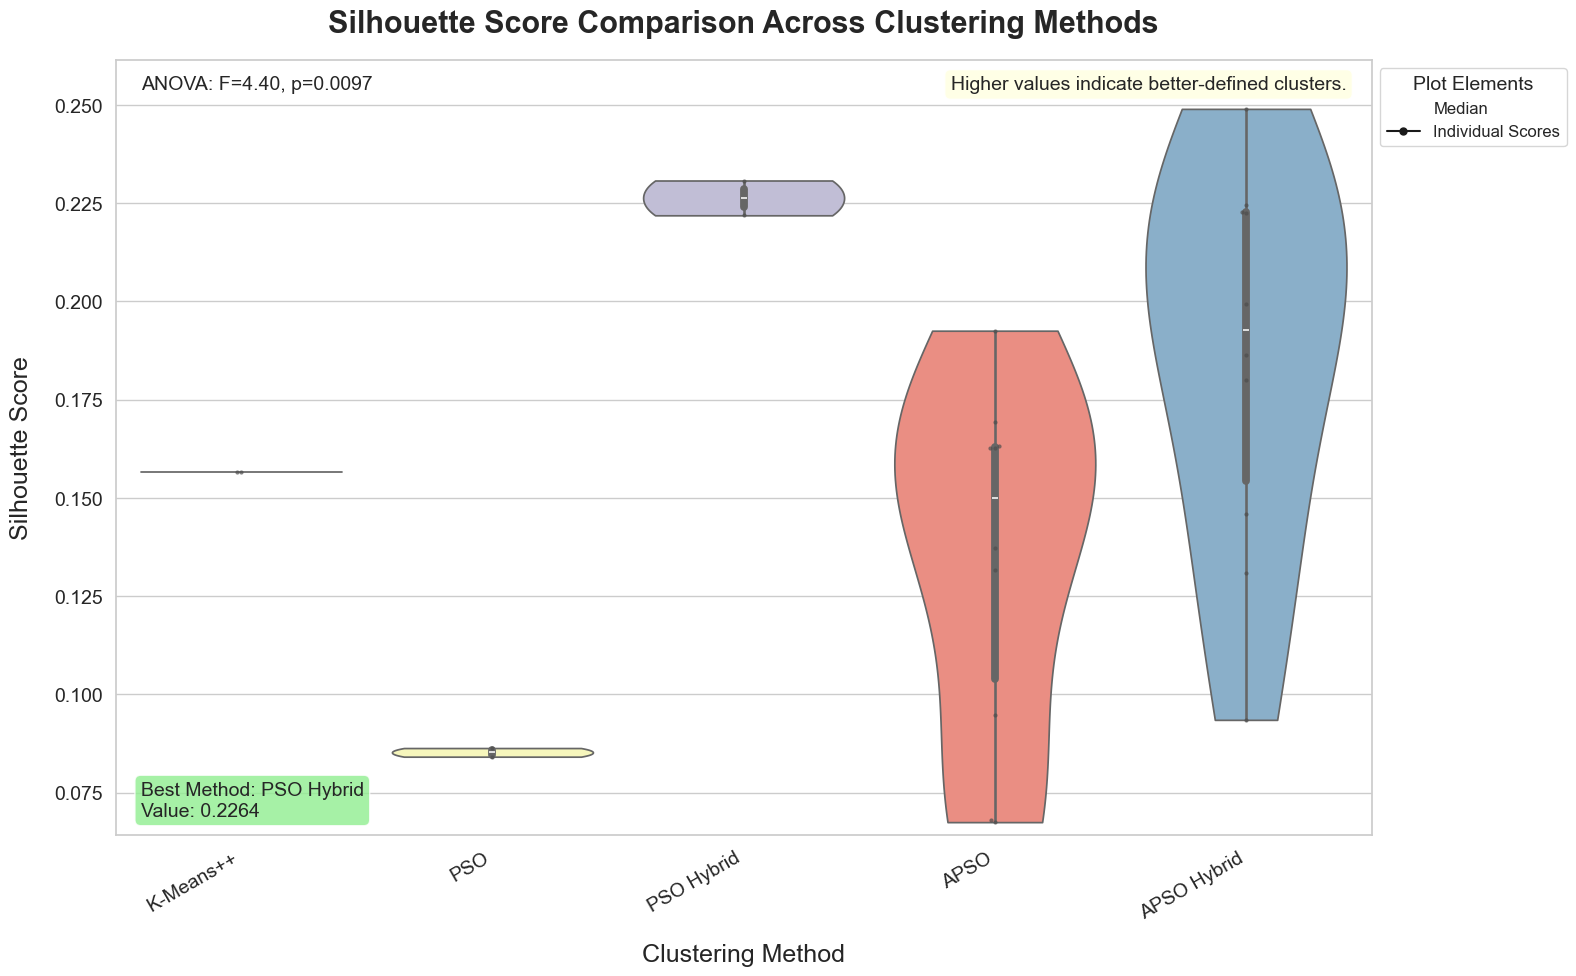

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats

def plot_actual_silhouette(results_dict, benchmark_df):
    # Prepare data
    data = []
    methods = ['K-Means++', 'PSO', 'PSO Hybrid', 'APSO', 'APSO Hybrid']
    for method in methods:
        if method == 'K-Means++':
            values = benchmark_df[benchmark_df['method'] == method]['silhouette_mean'].tolist() * len(results_dict['PSO']['silhouette'])
        else:
            values = results_dict[method]['silhouette']
        data.extend([(method, value) for value in values])
    
    df = pd.DataFrame(data, columns=['Method', 'Value'])

    plt.figure(figsize=(16, 10))
    sns.set_style("whitegrid")
    
    # Create violin plot with custom color palette
    sns.violinplot(x='Method', y='Value', data=df, 
                   palette='Set3', inner='box', cut=0)
    
    # Add swarm plot for individual points
    sns.swarmplot(x='Method', y='Value', data=df, 
                  color='.3', size=3, alpha=0.7)
    
    # Customize plot
    plt.title('Silhouette Score Comparison Across Clustering Methods', 
              fontsize=22, fontweight='bold', pad=20)
    plt.xlabel('Clustering Method', fontsize=18, labelpad=15)
    plt.ylabel('Silhouette Score', fontsize=18, labelpad=15)
    plt.xticks(rotation=30, ha='right', fontsize=14)
    plt.yticks(fontsize=14)
    
    # Adjust y-axis
    plt.ylim(df['Value'].min() * 0.95, df['Value'].max() * 1.05)
    
    # Add ANOVA results
    f_value, p_value = stats.f_oneway(*(df[df['Method'] == method]['Value'] for method in methods))
    anova_text = f"ANOVA: F={f_value:.2f}, p={p_value:.4f}"
    plt.text(0.02, 0.98, anova_text, transform=plt.gca().transAxes, fontsize=14,
             verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Add explanation
    explanation = "Higher values indicate better-defined clusters."
    plt.text(0.98, 0.98, explanation, transform=plt.gca().transAxes, fontsize=14,
             verticalalignment='top', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))
    
    # Highlight the best method
    best_method = df.groupby('Method')['Value'].mean().idxmax()
    best_value = df.groupby('Method')['Value'].mean().max()
    plt.text(0.02, 0.02, f"Best Method: {best_method}\nValue: {best_value:.4f}", 
             transform=plt.gca().transAxes, fontsize=14,
             verticalalignment='bottom', bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))
    
    # Add legend for violin plot parts
    handles, labels = plt.gca().get_legend_handles_labels()
    handles.extend([plt.Line2D([0], [0], color='w', marker='_', markersize=15, markerfacecolor='k', label='Median'),
                    plt.Line2D([0], [0], color='k', marker='o', markersize=5, label='Individual Scores')])
    plt.legend(handles=handles, title='Plot Elements', title_fontsize='14', fontsize='12', loc='upper left', bbox_to_anchor=(1, 1))
    
    plt.tight_layout()
    plt.show()

# Usage
plot_actual_silhouette({
    'PSO': pso_plain,
    'PSO Hybrid': pso_hybrid,
    'APSO': apso_plain,
    'APSO Hybrid': apso_hybrid
}, benchmark_df)

### Performance Ranking 🏆


In [38]:
import numpy as np
import pandas as pd

def calculate_statistics(data):
    return {
        'mean': np.around(np.mean(data), decimals=10),
        'stdev': np.around(np.std(data), decimals=10),
        'min': np.around(np.min(data), decimals=10),
        'max': np.around(np.max(data), decimals=10),
        'percentile_75': np.around(np.percentile(data, 75), decimals=10),
        'valid_count': np.sum(~np.isnan(data))
    }

def penalize_metric(value, success_rate, penalty_factor=1.0):
    """Penalize a metric based on success rate."""
    if np.isnan(value):
        return np.nan
    # For metrics where higher is better (e.g., silhouette)
    if 'silhouette' in metric:
        return value * (success_rate ** penalty_factor)
    # For metrics where lower is better (e.g., SSE, quantization)
    else:
        return value / (success_rate ** penalty_factor)

methods = ['K-Means++', 'PSO', 'PSO Hybrid', 'APSO', 'APSO Hybrid']
metrics = ['sse', 'silhouette', 'quantization']
results = [kmeanspp, pso_plain, pso_hybrid, apso_plain, apso_hybrid]

benchmark = {'method': methods}

for i, method in enumerate(methods):
    valid_runs = np.sum(~np.isnan(results[i][metrics[0]]))
    success_rate = valid_runs / 10  # 10 iterations
    benchmark['success_rate'] = benchmark.get('success_rate', []) + [success_rate]
    
    for metric in metrics:
        stats = calculate_statistics(results[i][metric])
        for stat, value in stats.items():
            if stat != 'valid_count':
                penalized_value = penalize_metric(value, success_rate)
                benchmark[f'{metric}_{stat}'] = benchmark.get(f'{metric}_{stat}', []) + [value]
                benchmark[f'{metric}_{stat}_penalized'] = benchmark.get(f'{metric}_{stat}_penalized', []) + [penalized_value]

benchmark_df = pd.DataFrame.from_dict(benchmark)

# Reorder columns
column_order = ['method', 'success_rate']
for metric in metrics:
    for stat in ['mean', 'stdev', 'min', 'max', 'percentile_75']:
        column_order.extend([f'{metric}_{stat}', f'{metric}_{stat}_penalized'])

benchmark_df = benchmark_df[column_order]

print(benchmark_df.to_string())

# Calculate overall score (example using penalized means)
benchmark_df['overall_score'] = (
    benchmark_df['silhouette_mean_penalized'] / benchmark_df['silhouette_mean_penalized'].max() -
    benchmark_df['sse_mean_penalized'] / benchmark_df['sse_mean_penalized'].max() -
    benchmark_df['quantization_mean_penalized'] / benchmark_df['quantization_mean_penalized'].max()
)

# Sort by overall score
benchmark_df_sorted = benchmark_df.sort_values('overall_score', ascending=False)
print("\nRanked by Overall Score:")
print(benchmark_df_sorted[['method', 'success_rate', 'overall_score']].to_string(index=False))

        method  success_rate     sse_mean  sse_mean_penalized    sse_stdev  sse_stdev_penalized      sse_min  sse_min_penalized       sse_max  sse_max_penalized  sse_percentile_75  sse_percentile_75_penalized  silhouette_mean  silhouette_mean_penalized  silhouette_stdev  silhouette_stdev_penalized  silhouette_min  silhouette_min_penalized  silhouette_max  silhouette_max_penalized  silhouette_percentile_75  silhouette_percentile_75_penalized  quantization_mean  quantization_mean_penalized  quantization_stdev  quantization_stdev_penalized  quantization_min  quantization_min_penalized  quantization_max  quantization_max_penalized  quantization_percentile_75  quantization_percentile_75_penalized
0    K-Means++           1.0  6543.524716         6543.524716   371.149133           371.149133  6123.421775        6123.421775   7104.026586        7104.026586        6866.355166                  6866.355166         0.156486                   0.156486          0.022908                    0.022908 

In [39]:
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def calculate_statistics(data):
    return {
        'mean': np.around(np.mean(data), decimals=10),
        'stdev': np.around(np.std(data), decimals=10),
        'min': np.around(np.min(data), decimals=10),
        'max': np.around(np.max(data), decimals=10),
        'percentile_75': np.around(np.percentile(data, 75), decimals=10),
        'valid_count': np.sum(~np.isnan(data))
    }

def penalize_metric(value, success_rate, metric, penalty_factor=1.0):
    """Penalize a metric based on success rate."""
    if np.isnan(value):
        return np.nan
    # For metrics where higher is better
    if metric in ['silhouette', 'calinski_harabasz']:
        return value * (success_rate ** penalty_factor)
    # For metrics where lower is better
    else:  # ['sse', 'quantization', 'davies_bouldin']
        return value / (success_rate ** penalty_factor)

def calculate_validation_scores(x, labels):
    """Calculate clustering validation scores."""
    if len(np.unique(labels)) < 2:
        return np.nan, np.nan, np.nan
    
    try:
        sil_score = silhouette_score(x, labels)
        ch_score = calinski_harabasz_score(x, labels)
        db_score = davies_bouldin_score(x, labels)
        return sil_score, ch_score, db_score
    except:
        return np.nan, np.nan, np.nan

def calculate_comprehensive_score(df, dataset_name):
    """Calculate comprehensive score considering all metrics and validation indices."""
    metrics = ['silhouette', 'sse', 'quantization', 'calinski_harabasz', 'davies_bouldin']
    stats = ['mean', 'percentile_75', 'max']
    
    # Initialize score components
    score_components = {}
    
    # Calculate normalized scores for each metric and statistic
    for metric in metrics:
        for stat in stats:
            col = f'{metric}_{stat}_penalized'
            norm_col = f'{metric}_{stat}_normalized'
            
            # Skip if column doesn't exist
            if col not in df.columns:
                continue
                
            if metric in ['silhouette', 'calinski_harabasz']:
                # Higher is better
                score_components[norm_col] = df[col] / df[col].max()
            else:
                # Lower is better
                score_components[norm_col] = 1 - (df[col] / df[col].max())
    
    # Create detailed scores DataFrame
    detailed_scores = pd.DataFrame(score_components)
    detailed_scores['method'] = df['method']
    detailed_scores['success_rate'] = df['success_rate']
    
    # Weights for different components
    metric_weights = {
        'silhouette': 0.25,
        'calinski_harabasz': 0.25,
        'davies_bouldin': 0.2,
        'sse': 0.15,
        'quantization': 0.15
    }
    
    stat_weights = {
        'mean': 0.25,
        'percentile_75': 0.5,
        'max': 0.25
    }
    
    # Calculate final score
    final_score = np.zeros(len(df))
    
    for metric in metrics:
        if f'{metric}_mean_normalized' not in score_components:
            continue
            
        metric_score = 0
        for stat in stats:
            norm_col = f'{metric}_{stat}_normalized'
            if norm_col in score_components:
                metric_score += score_components[norm_col] * stat_weights[stat]
        
        final_score += metric_score * metric_weights[metric]
    
    # Create summary DataFrame
    summary_cols = ['method', 'success_rate']
    for metric in metrics:
        if f'{metric}_mean' in df.columns:
            summary_cols.extend([f'{metric}_mean', f'{metric}_mean_penalized'])
    
    summary_df = pd.DataFrame({
        'dataset': dataset_name,
        'method': df['method'],
        'success_rate': df['success_rate'],
        'comprehensive_score': final_score,
        **{col: df[col] for col in summary_cols if col not in ['method', 'success_rate']}
    })
    
    # Add rank
    summary_df['rank'] = summary_df['comprehensive_score'].rank(ascending=False)
    
    return detailed_scores, summary_df

def process_dataset(data, methods, x, dataset_name, penalty_factor=1.0):
    """Process a single dataset including validation indices."""
    metrics = ['sse', 'silhouette', 'quantization', 'calinski_harabasz', 'davies_bouldin']
    benchmark = {'method': methods}
    
    for i, method in enumerate(methods):
        valid_runs = np.sum(~np.isnan(data[i]['sse']))  # Using SSE for valid run count
        success_rate = valid_runs / 10  # 10 iterations
        benchmark['success_rate'] = benchmark.get('success_rate', []) + [success_rate]
        
        # Calculate validation scores for the best clustering
        labels = labels_dict[method]
        sil, ch, db = calculate_validation_scores(x, labels)
        
        # Add validation scores to the results
        data[i]['calinski_harabasz'] = ch
        data[i]['davies_bouldin'] = db
        
        for metric in metrics:
            if metric in data[i]:
                stats = calculate_statistics(data[i][metric])
                for stat, value in stats.items():
                    if stat != 'valid_count':
                        penalized_value = penalize_metric(value, success_rate, metric, penalty_factor)
                        benchmark[f'{metric}_{stat}'] = benchmark.get(f'{metric}_{stat}', []) + [value]
                        benchmark[f'{metric}_{stat}_penalized'] = benchmark.get(f'{metric}_{stat}_penalized', []) + [penalized_value]
    
    benchmark_df = pd.DataFrame.from_dict(benchmark)
    detailed_scores, summary_df = calculate_comprehensive_score(benchmark_df, dataset_name)
    
    return benchmark_df, detailed_scores, summary_df

# Example usage
benchmark_df, detailed_scores, summary_df = process_dataset(
    results, methods, x, dataset_name="dataset1"
)

# Print results
print("\nDetailed Scores:")
print(detailed_scores.to_string())
print("\nFinal Rankings:")
print(summary_df[['method', 'success_rate', 'comprehensive_score', 'rank']].sort_values('rank').to_string())


Detailed Scores:
   silhouette_mean_normalized  silhouette_percentile_75_normalized  silhouette_max_normalized  sse_mean_normalized  sse_percentile_75_normalized  sse_max_normalized  quantization_mean_normalized  quantization_percentile_75_normalized  quantization_max_normalized  calinski_harabasz_mean_normalized  calinski_harabasz_percentile_75_normalized  calinski_harabasz_max_normalized  davies_bouldin_mean_normalized  davies_bouldin_percentile_75_normalized  davies_bouldin_max_normalized       method  success_rate
0                    0.843733                             0.809724                   0.763366             0.855775                      0.851611            0.849412                      0.794003                               0.796216                     0.794524                           1.000000                                    1.000000                          1.000000                        0.794721                                 0.794721                       0.79

### Export Results 💾


In [41]:
import numpy as np
import pandas as pd
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def calculate_statistics(data):
    """Calculate statistical measures for the data."""
    return {
        'mean': np.around(np.mean(data), decimals=10),
        'stdev': np.around(np.std(data), decimals=10),
        'min': np.around(np.min(data), decimals=10),
        'max': np.around(np.max(data), decimals=10),
        'percentile_75': np.around(np.percentile(data, 75), decimals=10),
        'valid_count': np.sum(~np.isnan(data))
    }

def penalize_metric(value, success_rate, metric, penalty_factor=1.0):
    """Penalize metric based on success rate and metric type."""
    if np.isnan(value):
        return np.nan
    if metric in ['silhouette', 'calinski_harabasz']:
        return value * (success_rate ** penalty_factor)
    else:  # ['sse', 'quantization', 'davies_bouldin']
        return value / (success_rate ** penalty_factor)

def calculate_validation_scores(x, labels):
    """Calculate clustering validation scores."""
    if len(np.unique(labels)) < 2:
        return np.nan, np.nan, np.nan
    try:
        sil_score = silhouette_score(x, labels)
        ch_score = calinski_harabasz_score(x, labels)
        db_score = davies_bouldin_score(x, labels)
        return sil_score, ch_score, db_score
    except:
        return np.nan, np.nan, np.nan

def calculate_comprehensive_score(df, dataset_name):
    """Calculate comprehensive score considering all metrics and validation indices."""
    metrics = ['silhouette', 'sse', 'quantization', 'calinski_harabasz', 'davies_bouldin']
    stats = ['mean', 'percentile_75', 'max']
    
    # Initialize score components
    score_components = {}
    
    # Calculate normalized scores for each metric and statistic
    for metric in metrics:
        for stat in stats:
            col = f'{metric}_{stat}_penalized'
            norm_col = f'{metric}_{stat}_normalized'
            
            if col not in df.columns:
                continue
                
            if metric in ['silhouette', 'calinski_harabasz']:
                # Higher is better
                score_components[norm_col] = df[col] / df[col].max()
            else:
                # Lower is better - use min/value so smaller values get higher scores
                score_components[norm_col] = df[col].min() / df[col]
    
    # Create detailed scores DataFrame
    detailed_scores = pd.DataFrame(score_components)
    detailed_scores['method'] = df['method']
    detailed_scores['success_rate'] = df['success_rate']
    
    # Weights for different components
    metric_weights = {
        'silhouette': 0.25,
        'calinski_harabasz': 0.25,
        'davies_bouldin': 0.2,
        'sse': 0.15,
        'quantization': 0.15
    }
    
    stat_weights = {
        'mean': 0.25,
        'percentile_75': 0.5,
        'max': 0.25
    }
    
    # Calculate final score
    final_score = np.zeros(len(df))
    
    for metric in metrics:
        if f'{metric}_mean_normalized' not in score_components:
            continue
            
        metric_score = 0
        for stat in stats:
            norm_col = f'{metric}_{stat}_normalized'
            if norm_col in score_components:
                metric_score += score_components[norm_col] * stat_weights[stat]
        
        final_score += metric_score * metric_weights[metric]
    
    # Create summary DataFrame
    summary_cols = ['method', 'success_rate']
    for metric in metrics:
        if f'{metric}_mean' in df.columns:
            summary_cols.extend([f'{metric}_mean', f'{metric}_mean_penalized'])
    
    summary_df = pd.DataFrame({
        'dataset': dataset_name,
        'method': df['method'],
        'success_rate': df['success_rate'],
        'comprehensive_score': final_score,
        **{col: df[col] for col in summary_cols if col not in ['method', 'success_rate']}
    })
    
    # Add rank
    summary_df['rank'] = summary_df['comprehensive_score'].rank(ascending=False)
    
    return detailed_scores, summary_df

def process_dataset(data, methods, x, dataset_name, penalty_factor=1.0):
    """Process a single dataset including validation indices."""
    metrics = ['sse', 'silhouette', 'quantization', 'calinski_harabasz', 'davies_bouldin']
    benchmark = {'method': methods}
    
    for i, method in enumerate(methods):
        valid_runs = np.sum(~np.isnan(data[i]['sse']))  # Using SSE for valid run count
        success_rate = valid_runs / 10  # 10 iterations
        benchmark['success_rate'] = benchmark.get('success_rate', []) + [success_rate]
        
        # Calculate validation scores for the best clustering
        labels = labels_dict[method]
        sil, ch, db = calculate_validation_scores(x, labels)
        
        # Add validation scores to the results
        data[i]['calinski_harabasz'] = ch
        data[i]['davies_bouldin'] = db
        
        for metric in metrics:
            if metric in data[i]:
                stats = calculate_statistics(data[i][metric])
                for stat, value in stats.items():
                    if stat != 'valid_count':
                        penalized_value = penalize_metric(value, success_rate, metric, penalty_factor)
                        benchmark[f'{metric}_{stat}'] = benchmark.get(f'{metric}_{stat}', []) + [value]
                        benchmark[f'{metric}_{stat}_penalized'] = benchmark.get(f'{metric}_{stat}_penalized', []) + [penalized_value]
    
    benchmark_df = pd.DataFrame.from_dict(benchmark)
    detailed_scores, summary_df = calculate_comprehensive_score(benchmark_df, dataset_name)
    
    return benchmark_df, detailed_scores, summary_df

def export_dataset_analysis(results, methods, x, dataset_name, main_csv='all_clustering_results.csv'):
    """
    Export dataset analysis results and append to main CSV.
    
    Parameters:
    -----------
    results : list
        Clustering results for each method
    methods : list
        List of clustering methods
    x : array-like
        Dataset being analyzed
    dataset_name : str
        Name of the dataset
    main_csv : str
        Name of the main CSV file to store all results
    """
    # Process dataset
    benchmark_df, detailed_scores, summary_df = process_dataset(results, methods, x, dataset_name)
    
    # Create results DataFrame
    results_df = pd.DataFrame()
    results_df['Dataset'] = [str(dataset_name)] * len(methods)  # Ensure dataset name is string
    results_df['Method'] = methods
    results_df['Success_Rate'] = benchmark_df['success_rate']
    results_df['Final_Score'] = summary_df['comprehensive_score']
    results_df['Rank'] = summary_df['rank']
    
    # Add all metrics
    metrics = ['silhouette', 'calinski_harabasz', 'davies_bouldin', 'sse', 'quantization']
    stats = ['mean', 'percentile_75', 'max']
    
    for metric in metrics:
        for stat in stats:
            col = f'{metric}_{stat}'
            if col in benchmark_df.columns:
                results_df[f'{metric}_{stat}'] = benchmark_df[col]
                if f'{col}_penalized' in benchmark_df.columns:
                    results_df[f'{metric}_{stat}_penalized'] = benchmark_df[f'{col}_penalized']
    
    # Add normalized scores
    for metric in metrics:
        for stat in stats:
            norm_col = f'{metric}_{stat}_normalized'
            if norm_col in detailed_scores.columns:
                results_df[norm_col] = detailed_scores[norm_col]
    
    # Handle main CSV file
    try:
        main_df = pd.read_csv(main_csv)
        # Convert Dataset column to string type
        main_df['Dataset'] = main_df['Dataset'].astype(str)
        # Remove previous results for this dataset if they exist
        main_df = main_df[main_df['Dataset'] != str(dataset_name)]
        # Append new results
        main_df = pd.concat([main_df, results_df], ignore_index=True)
    except FileNotFoundError:
        main_df = results_df
    
    # Save to main CSV
    main_df.to_csv(main_csv, index=False)
    
    # Print simple summary
    print(f"\nResults for {dataset_name} dataset added to {main_csv}")
    unique_datasets = sorted(main_df['Dataset'].unique().astype(str))
    print(f"Datasets in main CSV: {', '.join(unique_datasets)}")
    
    return results_df

export_dataset_analysis(results, methods, x, "Dermitology")



Results for Dermitology dataset added to all_clustering_results.csv
Datasets in main CSV: Dermitology, Iris, Wisconsin Breast Cancer


Dataset       Method  Success_Rate  Final_Score  Rank  silhouette_mean  \
0  Dermitology    K-Means++           1.0     0.916808   2.0         0.156486   
1  Dermitology          PSO           0.2     0.115711   5.0         0.085218   
2  Dermitology   PSO Hybrid           0.2     0.204338   4.0         0.226354   
3  Dermitology         APSO           1.0     0.815421   3.0         0.134936   
4  Dermitology  APSO Hybrid           1.0     0.948205   1.0         0.185469   

   silhouette_mean_penalized  silhouette_percentile_75  \
0                   0.156486                  0.180359   
1                   0.017044                  0.085767   
2                   0.045271                  0.228569   
3                   0.134936                  0.163074   
4                   0.185469                  0.222741   

   silhouette_percentile_75_penalized  silhouette_max  ...  \
0                            0.180359        0.190088  ...   
1                            0.017153        0.086316  ...   
2                            0.045714        0.230783  ...   
3                            0.163074        0.192552  ...   
4                            0.222741        0.249014  ...   

   calinski_harabasz_max_normalized  davies_bouldin_mean_normalized  \
0                          1.000000                        0.847987   
1                          0.001312                        0.217930   
2                          0.200240                        0.174074   
3                          0.760773                        1.000000   
4                          0.999250                        0.849279   

   davies_bouldin_percentile_75_normalized  davies_bouldin_max_normalized  \
0                                 0.847987                       0.847987   
1                                 0.217930                       0.217930   
2                                 0.174074                       0.174074   
3                                 1.000000                       1.000000   
4                                 0.849279                       0.849279   

   sse_mean_normalized  sse_percentile_75_normalized  sse_max_normalized  \
0             1.000000                      0.974417            1.000000   
1             0.144225                      0.144592            0.150588   
2             0.230825                      0.234312            0.247003   
3             0.682391                      0.641686            0.613851   
4             0.889073                      1.000000            0.545243   

   quantization_mean_normalized  quantization_percentile_75_normalized  \
0                      0.955478                               0.988529   
1                      0.196826                               0.201446   
2                      0.202286                               0.209971   
3                      0.955173                               0.957655   
4                      1.000000                               1.000000   

   quantization_max_normalized  
0                     1.000000  
1                     0.205476  
2                     0.217164  
3                     0.947559  
4                     0.993335  

[5 rows x 50 columns]